# Baseline 

#### Using the following paper: https://arxiv.org/abs/1910.03182

## Imports

In [58]:
import cv2
import time
import numpy as np
import pymeanshift as pms
import os
import pandas as pd
from matplotlib import pyplot as plt
from ipyfilechooser import FileChooser
from IPython.display import clear_output

## File Chooser

In [2]:
# Create and display a FileChooser widget
fc = FileChooser('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset')
display(fc)

FileChooser(path='C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset', filename='', title='', show_hidden=False…

## Main Algorithm

### Mean Shift Segmentation Approach

https://github.com/fjean/pymeanshift

In [3]:
def mean_shift(img, processing_shape=(256,256), spatial_radius=6, range_radius=4.5, min_density=50): 
    
    original_shape = img.shape
    img = cv2.resize(img, processing_shape)
    (segmented_image, labels_image, number_regions) = pms.segment(img, spatial_radius=spatial_radius, range_radius=range_radius, min_density=min_density)

    #take the upper half of labels_image and take the most dominant label in the upper half
    upper_labels = labels_image[0:labels_image.shape[0]//2, 0:labels_image.shape[1]]
    unique, counts = np.unique(upper_labels, return_counts=True)
    dominant_label = unique[np.argmax(counts)]

    #create a mask from labels_image where dominant_label is sky and resize it to original shape
    mask = np.zeros(labels_image.shape, dtype=np.uint8)
    mask[labels_image == dominant_label] = 1
    mask = cv2.resize(mask, (original_shape[1],original_shape[0]))

    return mask, segmented_image, labels_image
    

#### Display Results

In [4]:
def display_results(filename, display_mode='display', data_mode = 'display', spatial_radius=4, range_radius=4, min_density= 50): 
    
    start_time = time.time()
    img = plt.imread(filename)
    mask, segmented_image, labels_image = mean_shift(img, spatial_radius=spatial_radius, range_radius=range_radius, min_density=min_density)
    time_taken = time.time() - start_time

    after_img = cv2.bitwise_and(img, img, mask=mask)

    #display the images in 2 subplots 
    if display_mode == 'display':
        print('------------------------------------------------------------------------------------------------------------------------')
        print("Processing: " + filename.split("\\")[-2] + ", spatial_radius: " + str(spatial_radius) + ", range_radius: " + str(range_radius) + ", min_density: " + str(min_density))
        print('Time taken: ', time_taken)
        
        plt.title('Segmented Image')
        plt.imshow(segmented_image)
        plt.show()

        plt.title('Labels Image')
        plt.imshow(labels_image)
        plt.show()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
        fig.suptitle('Sky Segmentation')
        ax1.imshow(after_img)
        ax1.set_title('Result')
        ax2.imshow(plt.imread(filename))
        ax2.set_title('Original Image')
        plt.show()

        if data_mode == 'validate':
            val_image = cv2.imread("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\ValidationImages\\Skyfinder\\" + filename.split("\\")[-2] + ".png")
            val_image = cv2.cvtColor(val_image, cv2.COLOR_BGR2GRAY)

            #calculate the precision and recall
            true_pos = np.sum(np.logical_and(val_image, mask))
            false_pos = np.sum(np.logical_and(np.logical_not(val_image), mask))
            false_neg = np.sum(np.logical_and(val_image, np.logical_not(mask)))
            precision = true_pos / (true_pos + false_pos)
            recall = true_pos / (true_pos + false_neg)
            f1 = 2 * (precision * recall) / (precision + recall)

            print("Precision: " + str(precision))
            print("Recall: " + str(recall))
            print("F1: " + str(f1))

            print('------------------------------------------------------------------------------------------------------------------------')
            return [precision, recall, f1, filename, time_taken, spatial_radius, range_radius, min_density]
        
        elif data_mode == 'display':
            print('------------------------------------------------------------------------------------------------------------------------')
            return [0, 0, 0, filename, time_taken, spatial_radius, range_radius, min_density]
        
    else:
        if data_mode == 'validate':
            val_image = cv2.imread("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\ValidationImages\\Skyfinder\\" + filename.split("\\")[-2] + ".png")
            val_image = cv2.cvtColor(val_image, cv2.COLOR_BGR2GRAY)

            #calculate the precision and recall
            true_pos = np.sum(np.logical_and(val_image, mask))
            false_pos = np.sum(np.logical_and(np.logical_not(val_image), mask))
            false_neg = np.sum(np.logical_and(val_image, np.logical_not(mask)))
            precision = true_pos / (true_pos + false_pos)
            recall = true_pos / (true_pos + false_neg)
            f1 = 2 * (precision * recall) / (precision + recall)

            return [precision, recall, f1, filename, time_taken, spatial_radius, range_radius, min_density]
        
        elif data_mode == 'display':
            return [0, 0, 0, filename, time_taken, spatial_radius, range_radius, min_density]
        


#### Individual Image Testing

41
------------------------------------------------------------------------------------------------------------------------
Processing: 8733, spatial_radius: 1, range_radius: 1, min_density: 150
Time taken:  0.09994268417358398


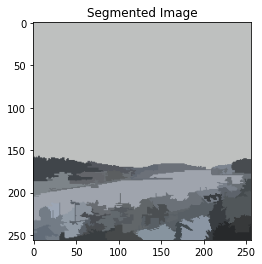

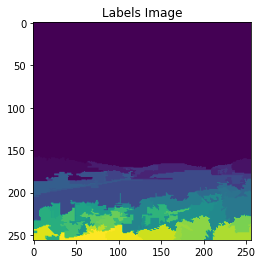

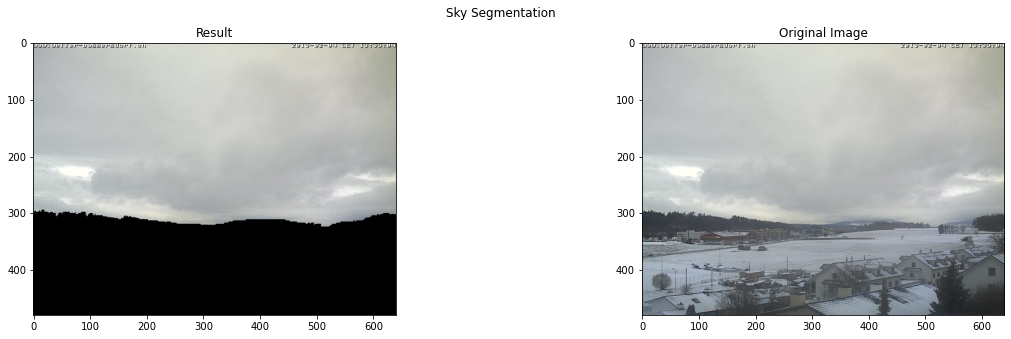

Precision: 0.9750759083871228
Recall: 0.9991552052748158
F1: 0.9869687116782936
------------------------------------------------------------------------------------------------------------------------


In [22]:
_ = display_results(fc.selected, display_mode = 'display',data_mode='validate', spatial_radius=2, range_radius=8, min_density=150)

### Data for random 1000 images

In [8]:
sr_array = [i for i in range(0, 3, 1)]
rr_array = [i for i in range(2, 16, 2)]
min_array = [i for i in range(150, 550, 100)]

results = pd.DataFrame(columns=['precision', 'recall', 'f1', 'filename', 'time_taken', 'spatial_radius', 'range_radius', 'min_density'])

#iterate through 1000 random images
files = [os.path.join(dp, f) for dp, dn, filenames in os.walk("C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\OriginalImages") for f in filenames if os.path.splitext(f)[1] == '.jpg']
random = [np.random.randint(0, len(files)) for i in range(0, 100)]
counter = 0
for i in random:
    counter += 1
    for j in sr_array:
        for k in rr_array:
            for l in min_array:
                clear_output(wait=True)
                print("File Number " + str(counter) + "/100 - " + str(files[i]) + "\nspatial_radius=" + str(j) + ": \n     range_radius=" + str(k) + ": \n          min_density=" + str(l) + ": ")
                results.loc[len(results)] = display_results(files[i], display_mode = 'not_display' ,data_mode='validate', spatial_radius=j, range_radius=k, min_density=l)

#remove all nan values from results
results = results.dropna()

#save the results to a csv file
results.to_csv('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\results_0_1.csv')

File Number 100/100 - C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\OriginalImages\162\20130810_200826.jpg
spatial_radius=2: 
     range_radius=14: 
          min_density=450: 


### Importing the saved result data

For Results ranging from 2 to 14 for Spatial Radius

In [11]:
sr_array = [i for i in range(2, 16, 2)]
rr_array = [i for i in range(2, 16, 2)]
min_array = [i for i in range(150, 550, 100)]

#import the results from the csv file with the first column as the index
results = pd.read_csv('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\results_sr_2_14.csv', index_col=0)

For Results ranging from 0 to 2 for Spatial Radius

In [6]:
sr_array = [i for i in range(0, 3, 1)]
rr_array = [i for i in range(2, 16, 2)]
min_array = [i for i in range(150, 550, 100)]

#import the results from the csv file with the first column as the index
results = pd.read_csv('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\results_sr_0_2.csv', index_col=0)

### Display the results in 3D

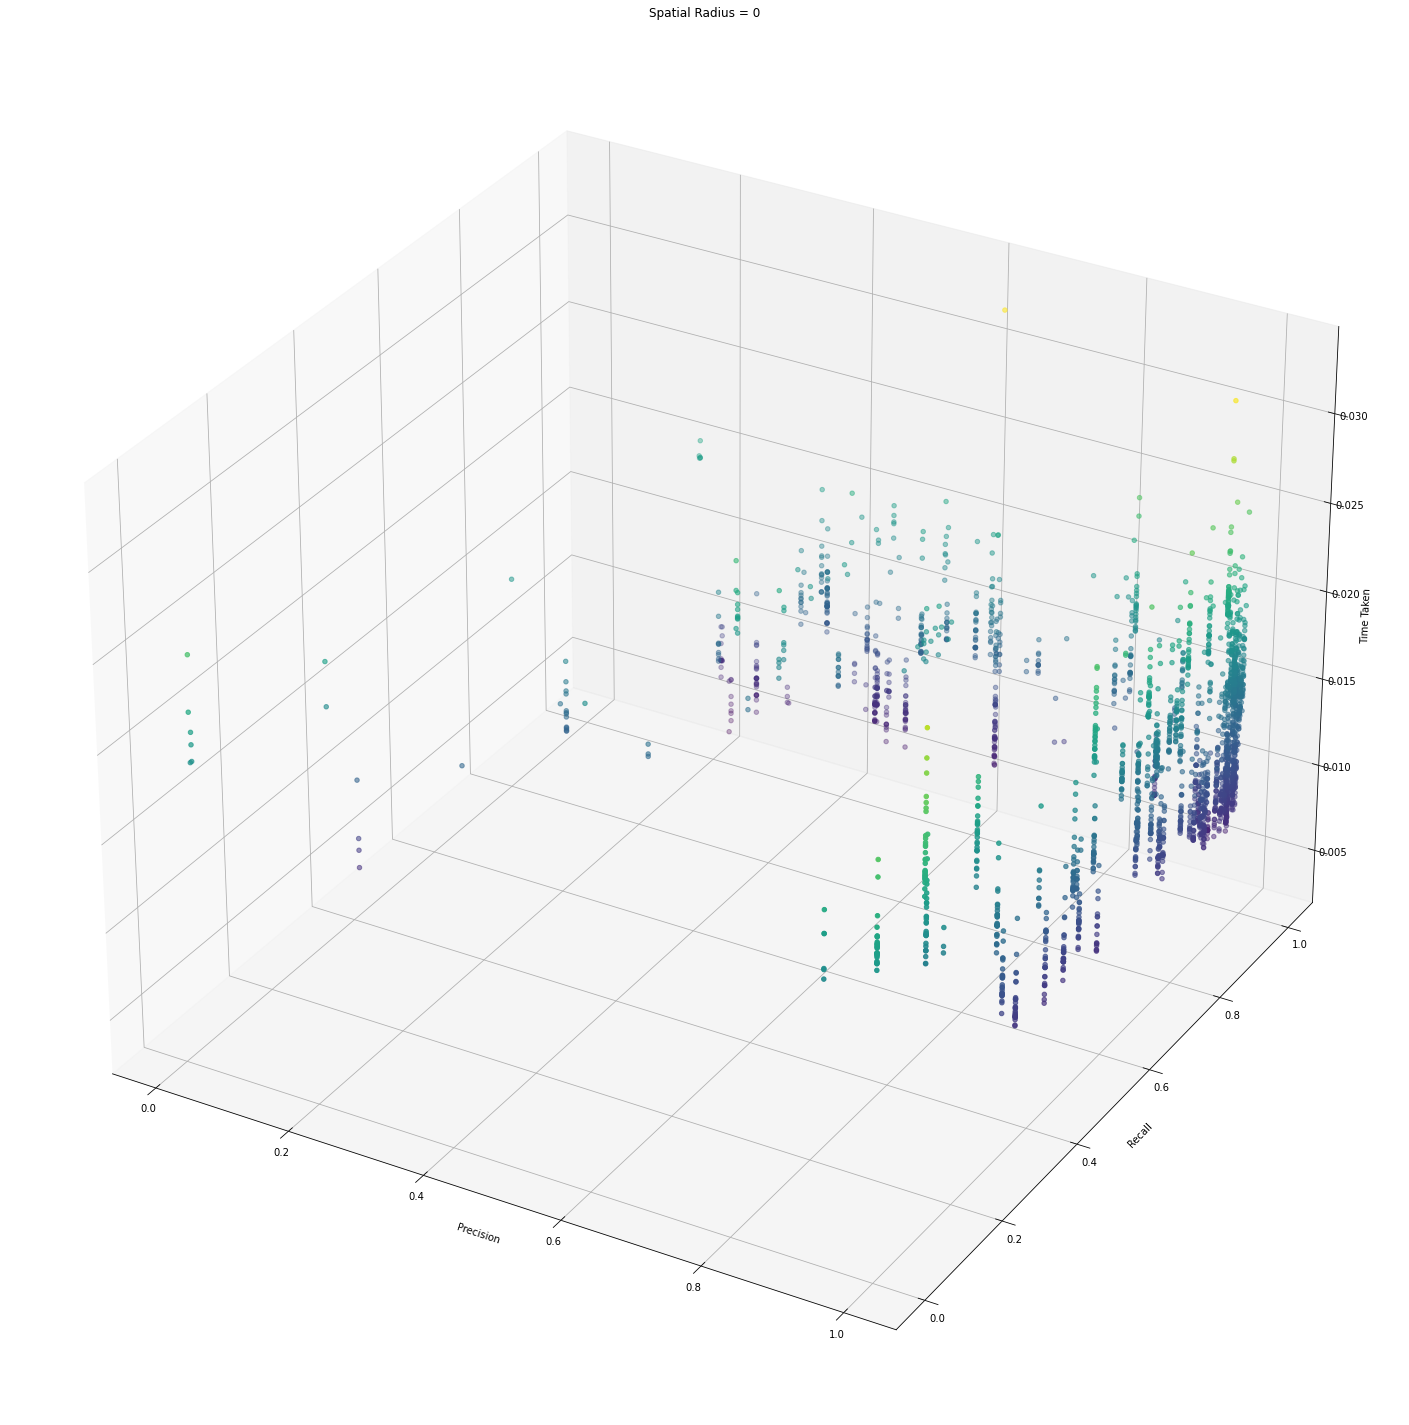

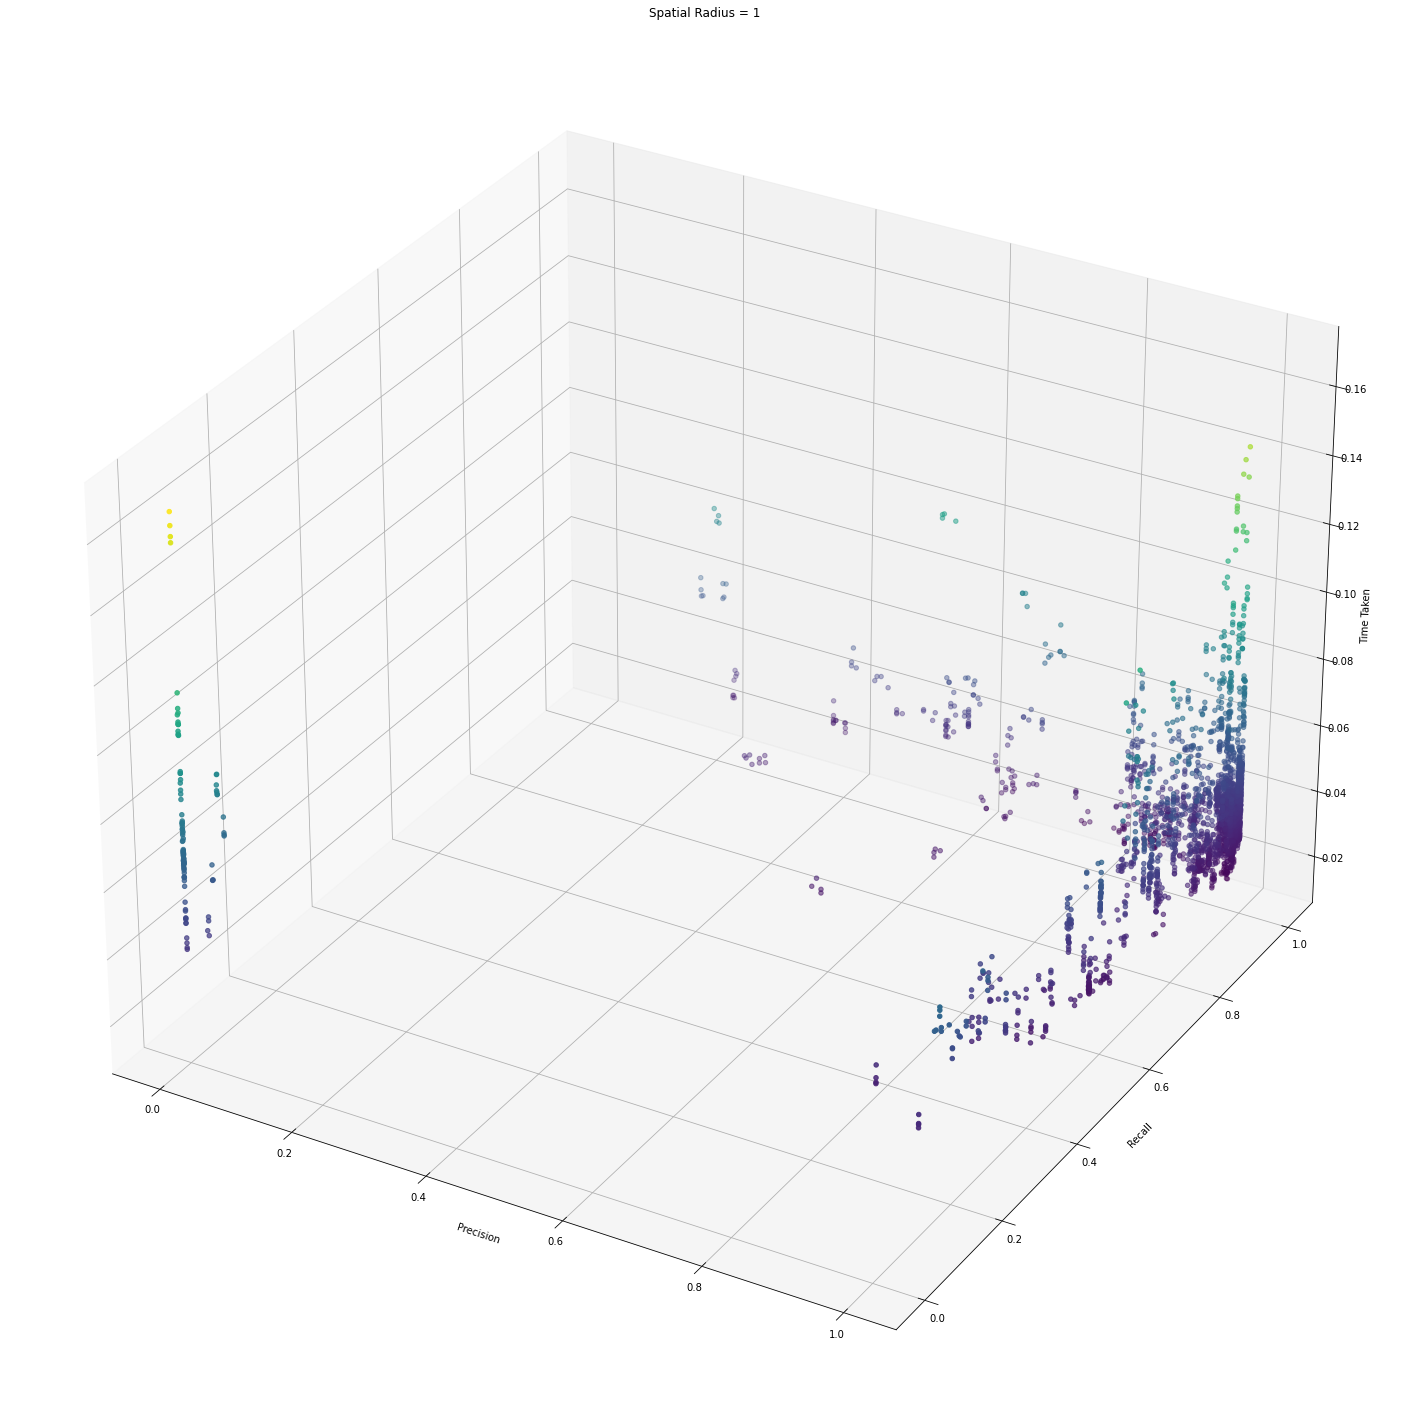

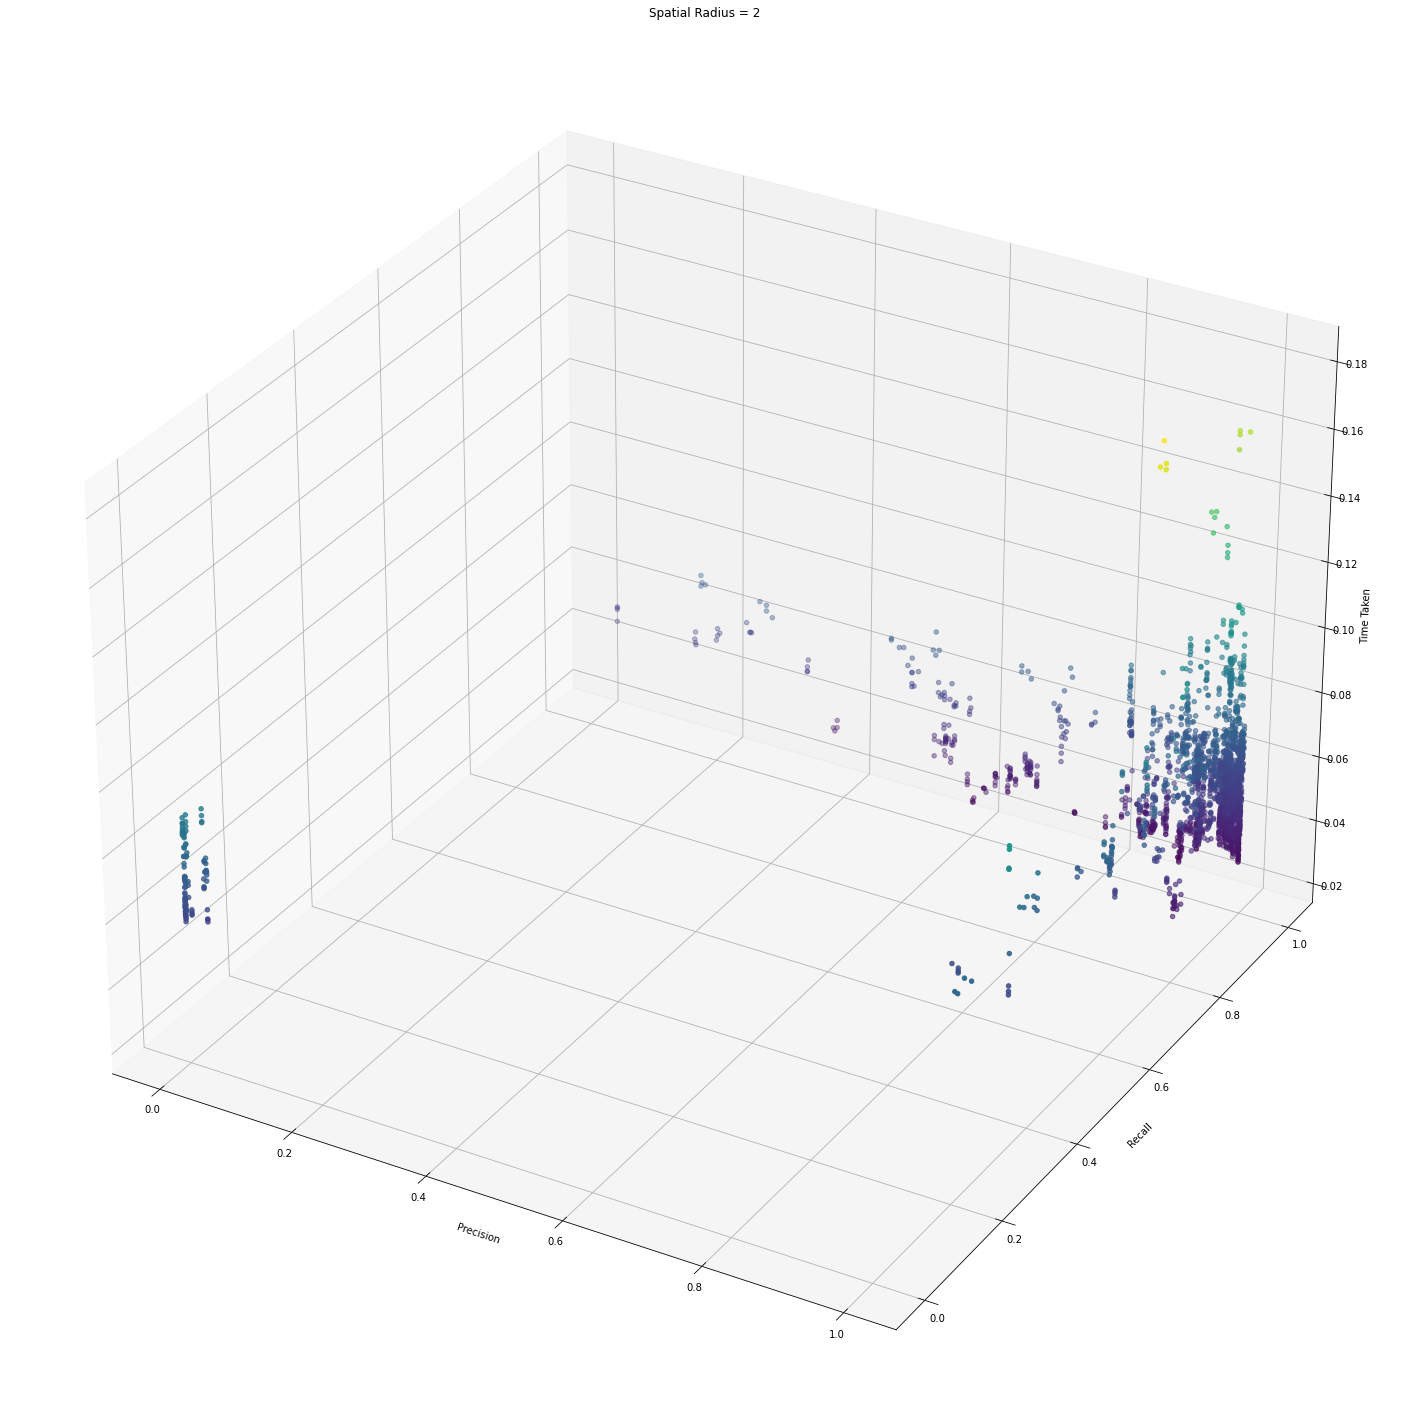

In [10]:
#make a 3d plot of the result for precision, recall and time taken for each spatial_radius
for i in sr_array:
    fig = plt.figure(figsize=(25, 30))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(results['precision'][results['spatial_radius'] == i], results['recall'][results['spatial_radius'] == i], results['time_taken'][results['spatial_radius'] == i], c=results['time_taken'][results['spatial_radius'] == i], cmap='viridis')
    ax.set_xlabel('Precision')
    ax.set_ylabel('Recall')
    ax.set_zlabel('Time Taken')
    ax.set_title('Spatial Radius = ' + str(i))
    plt.show()

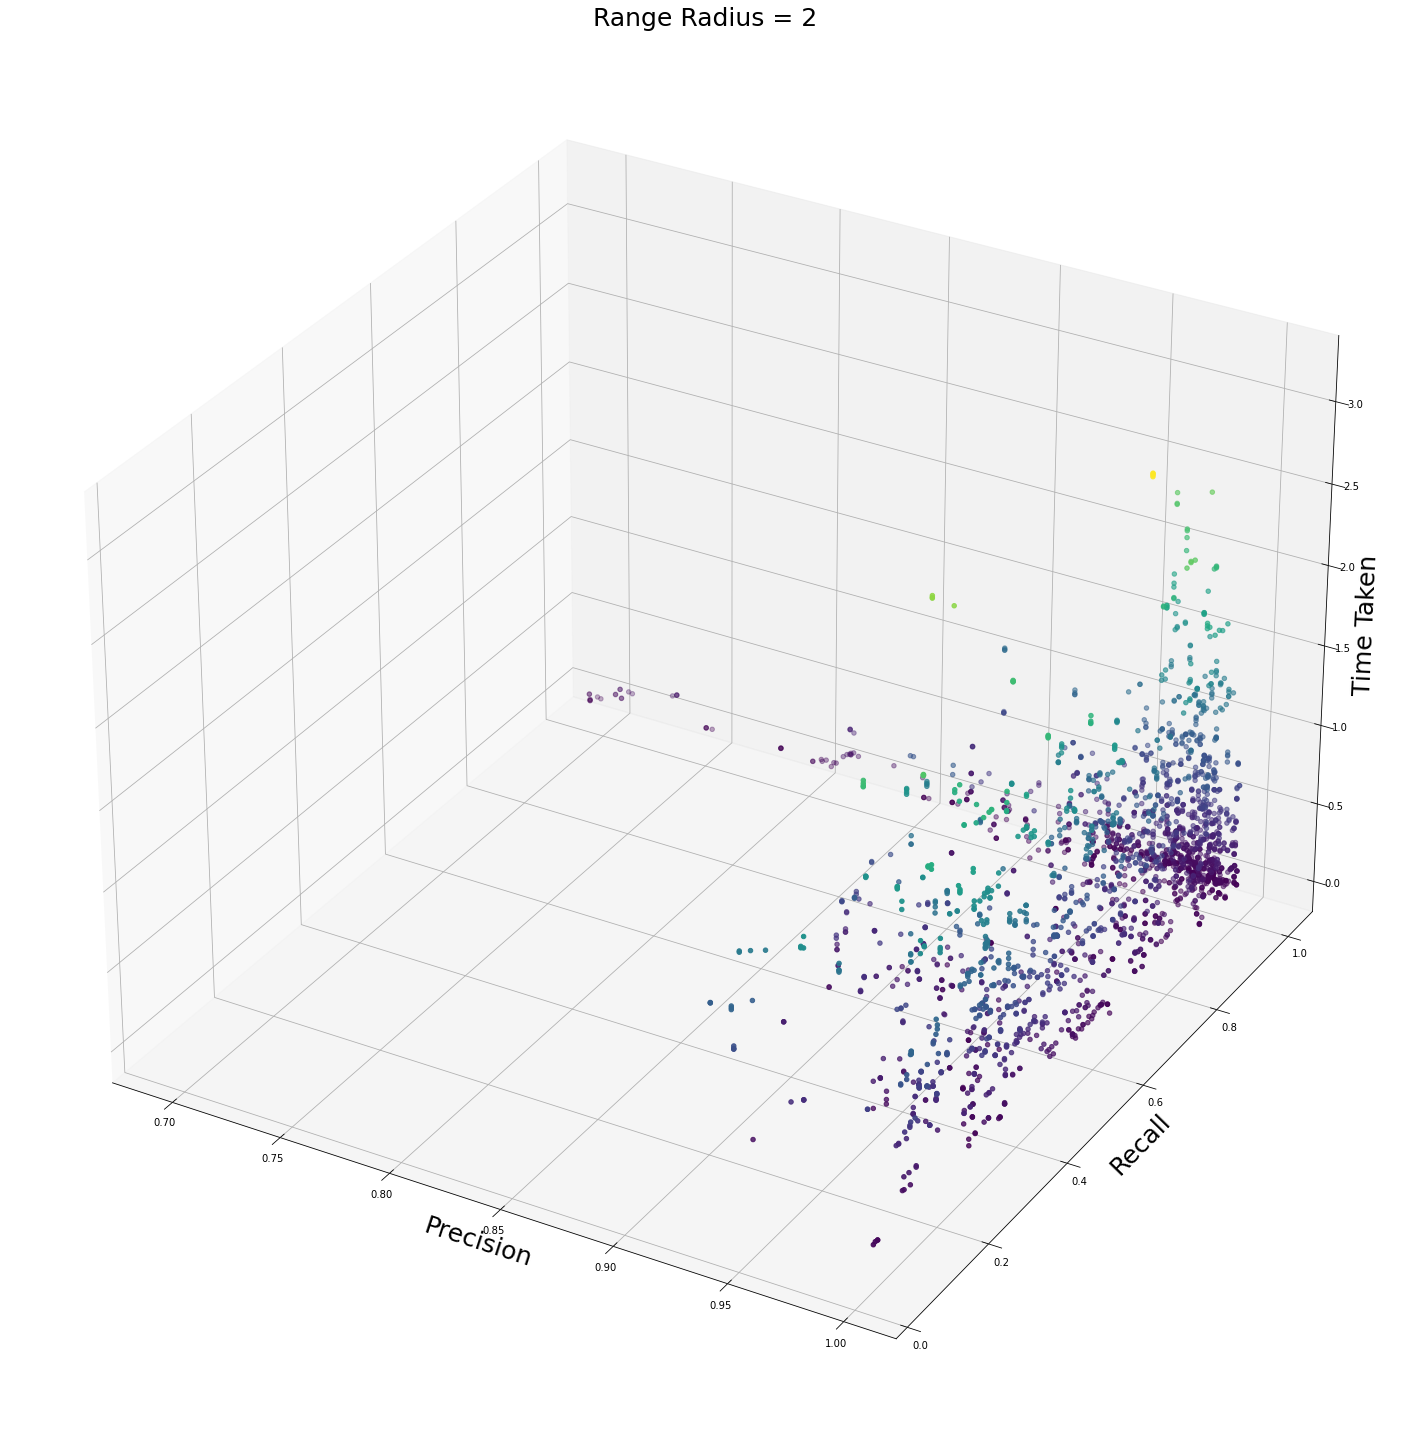

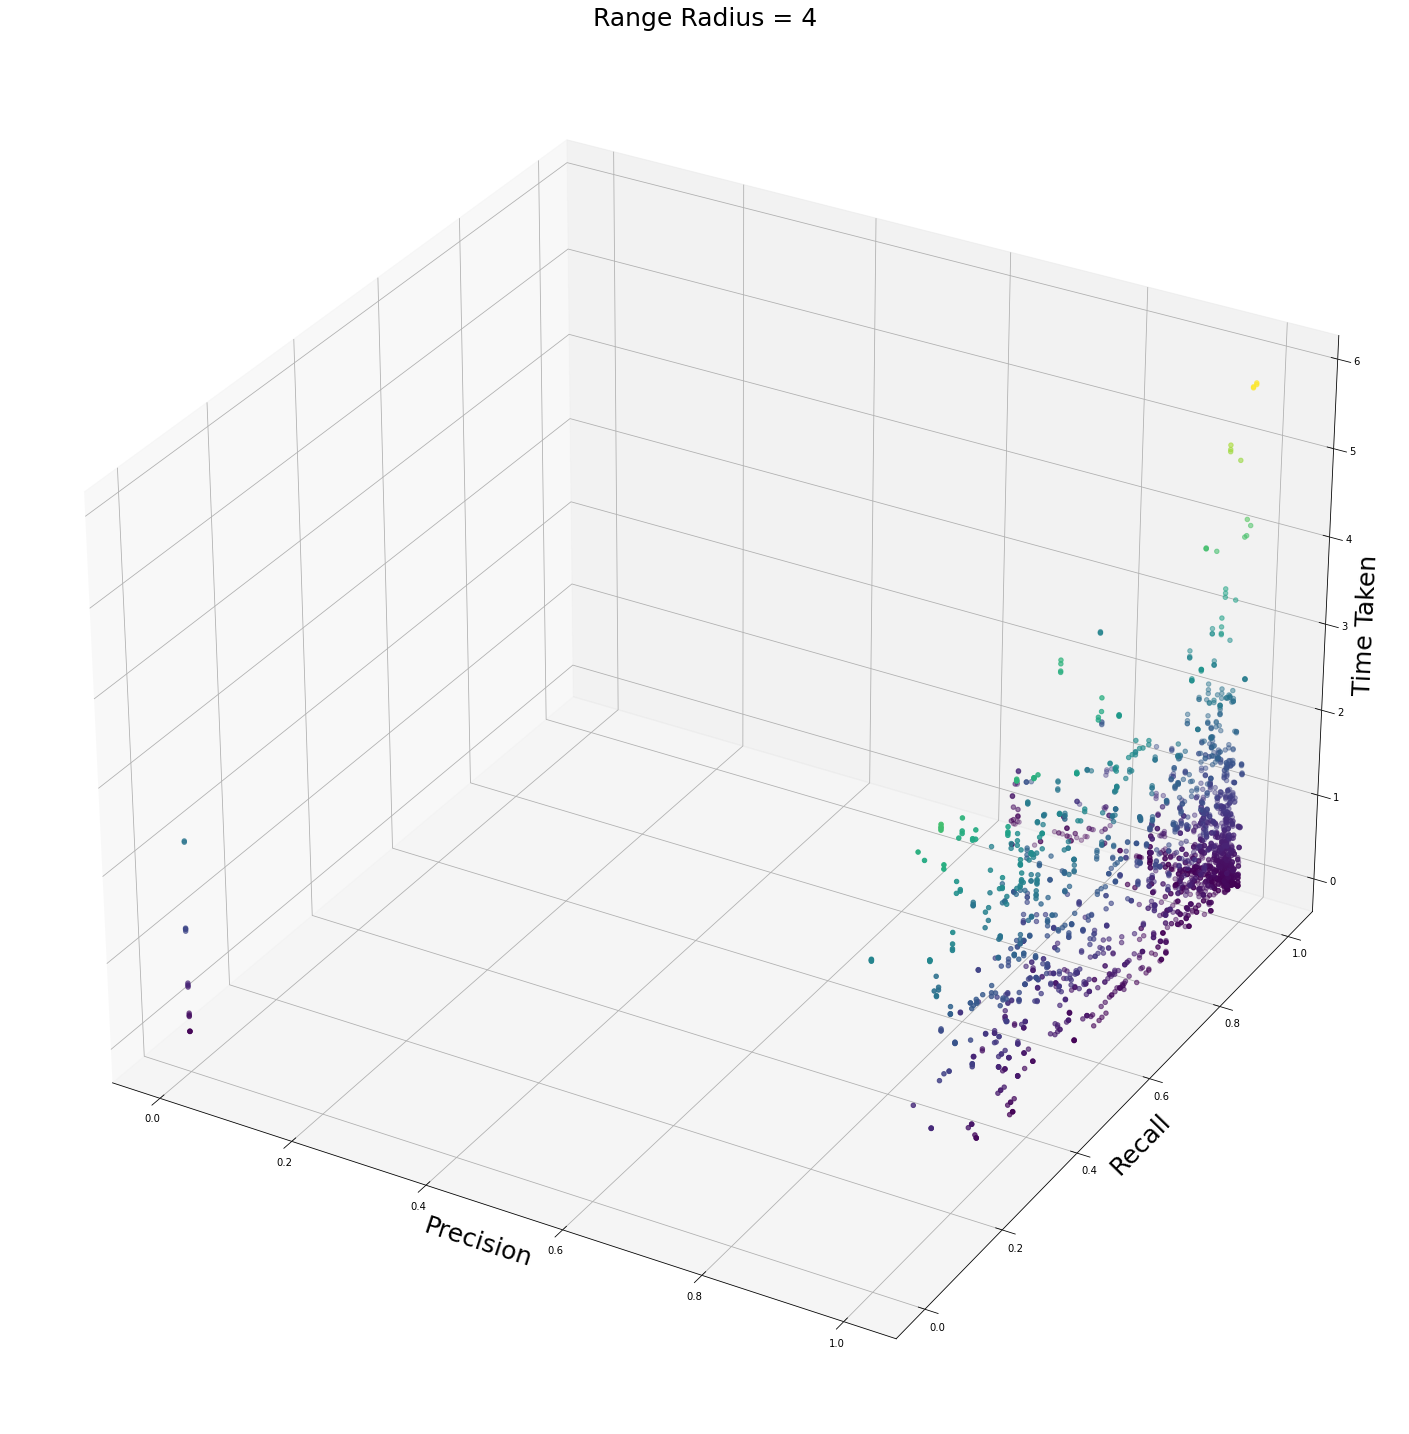

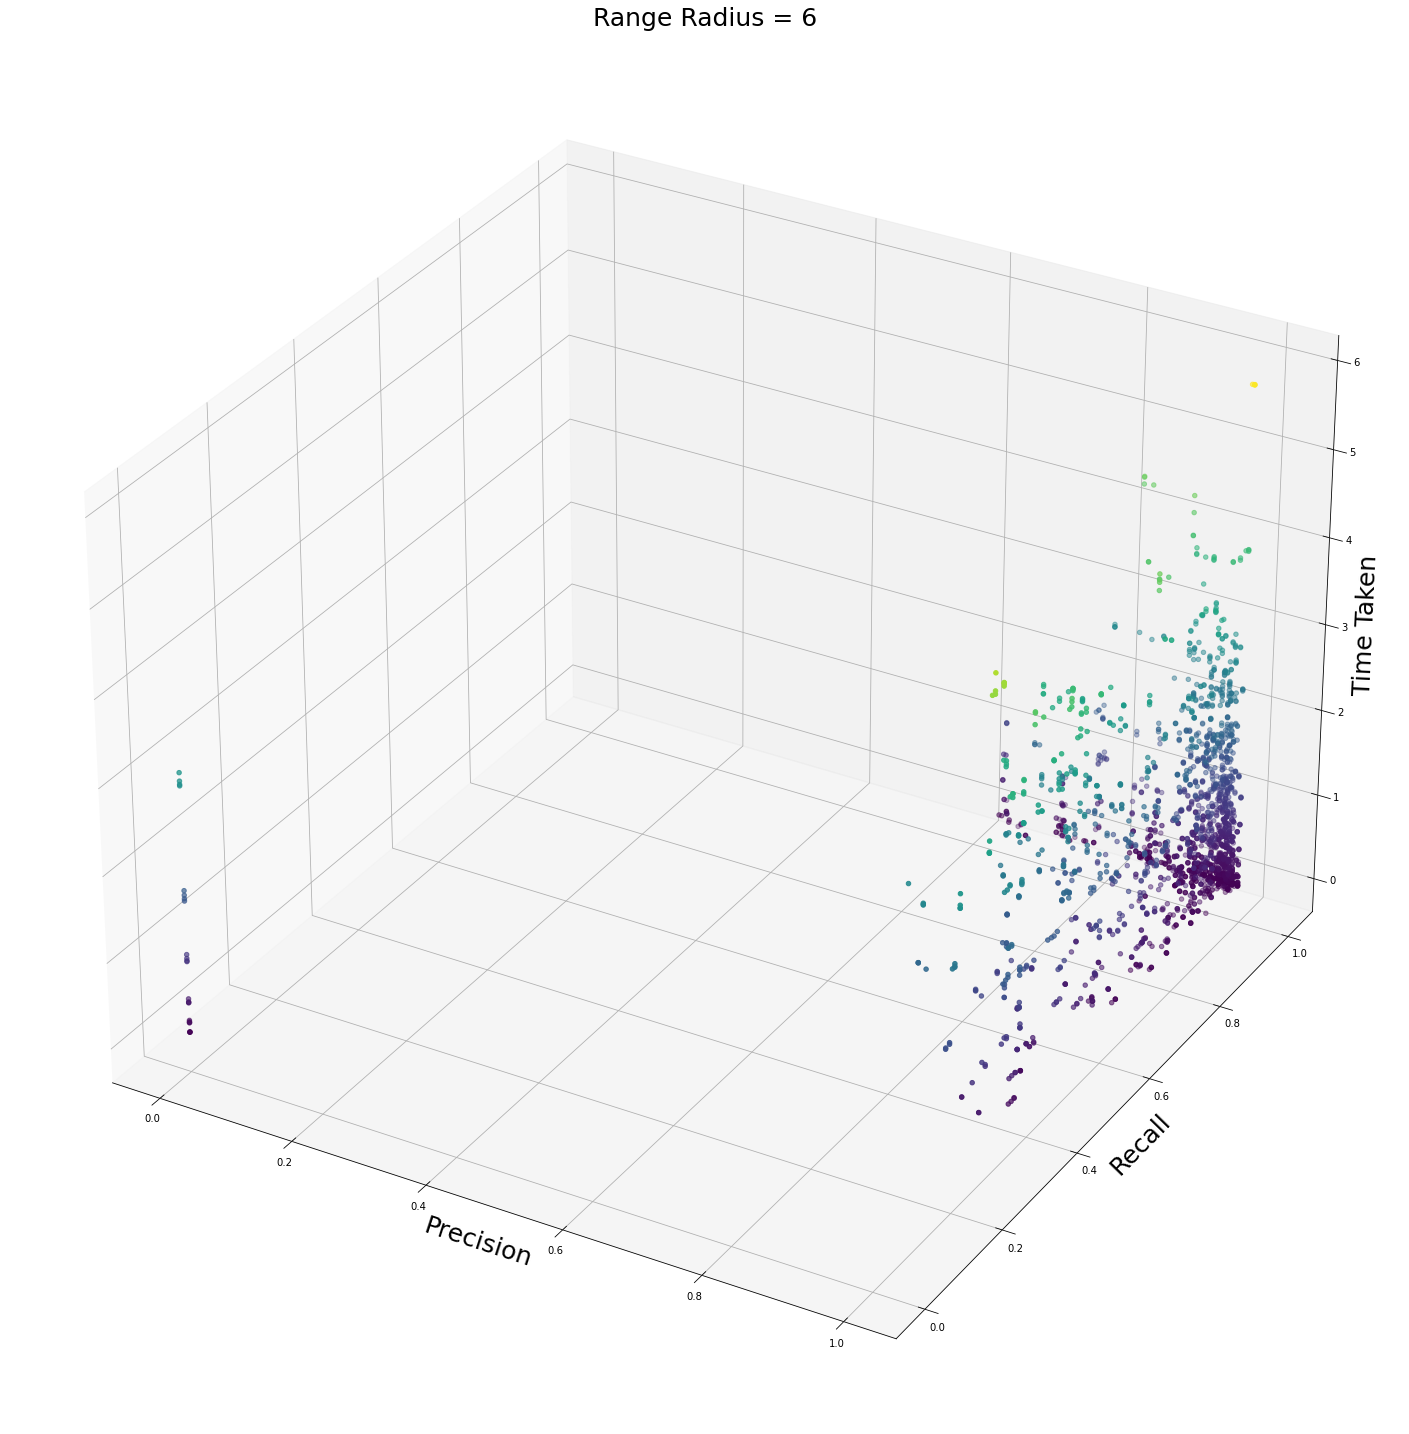

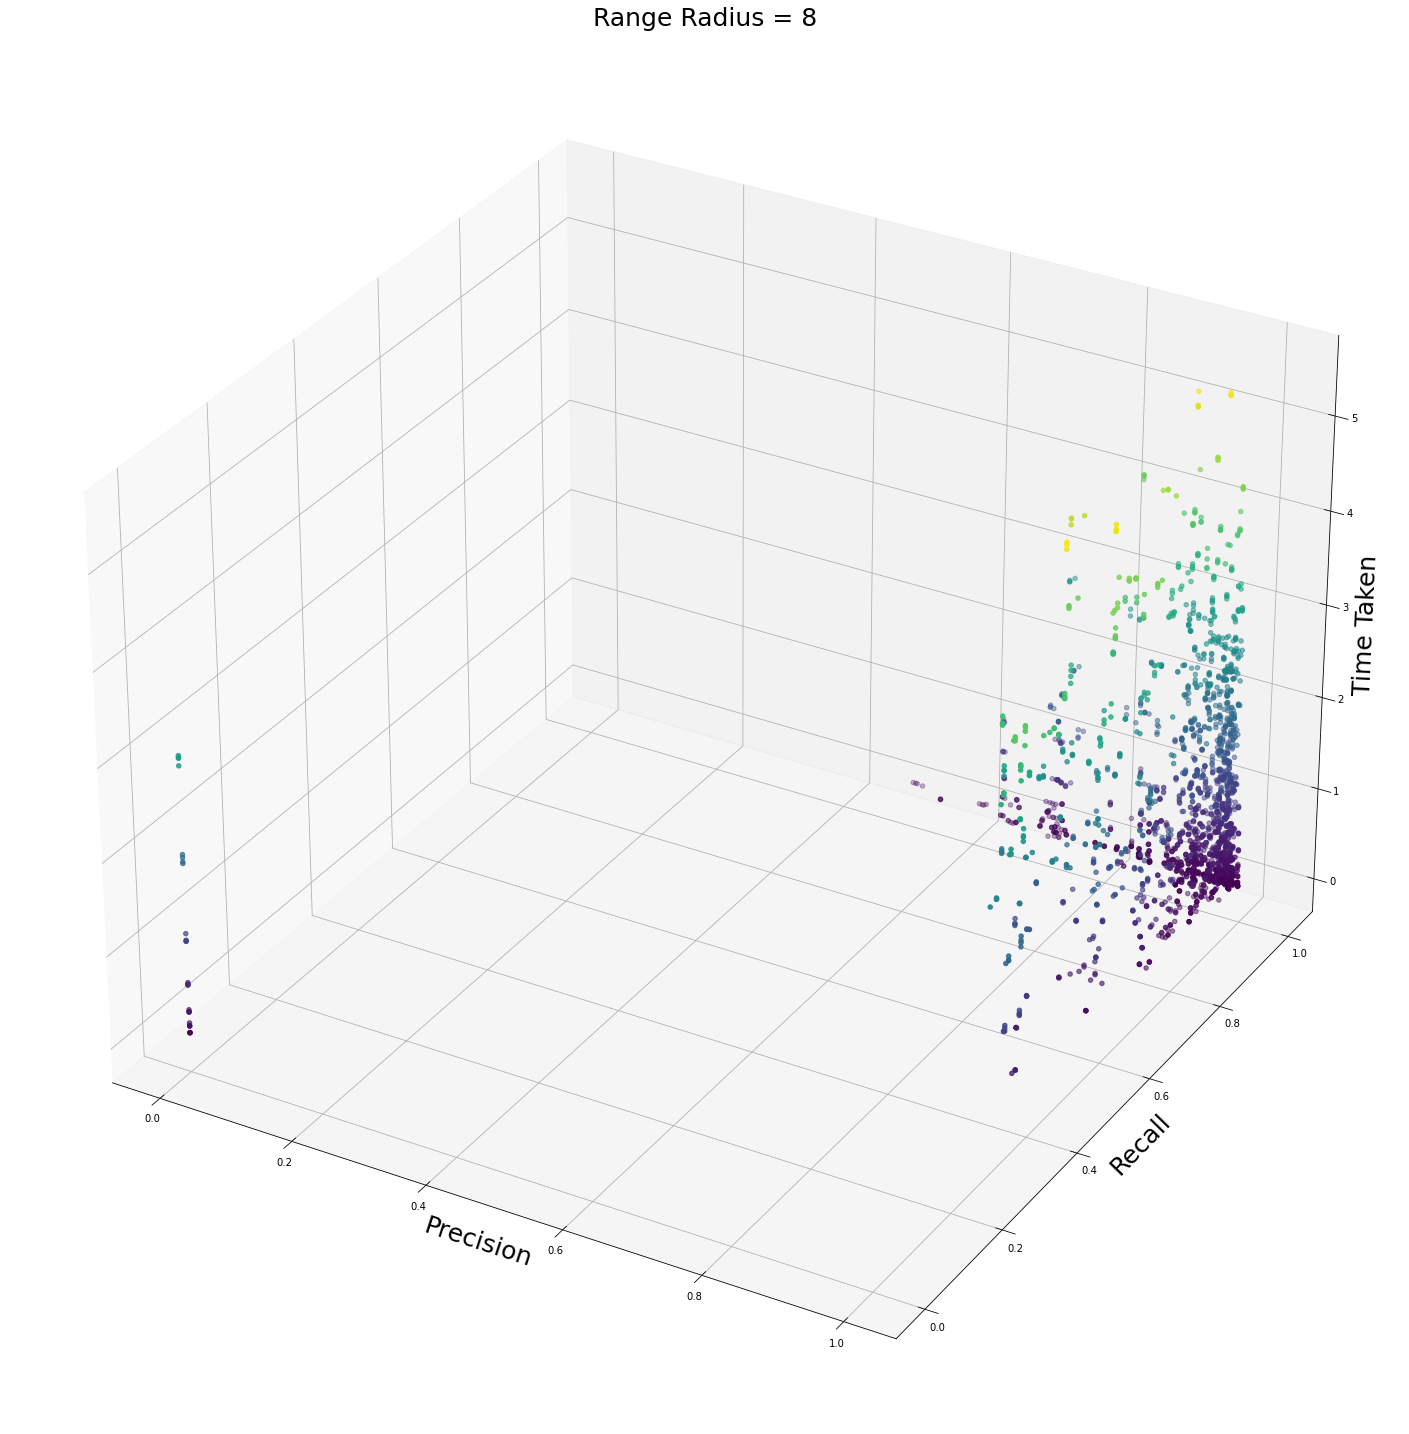

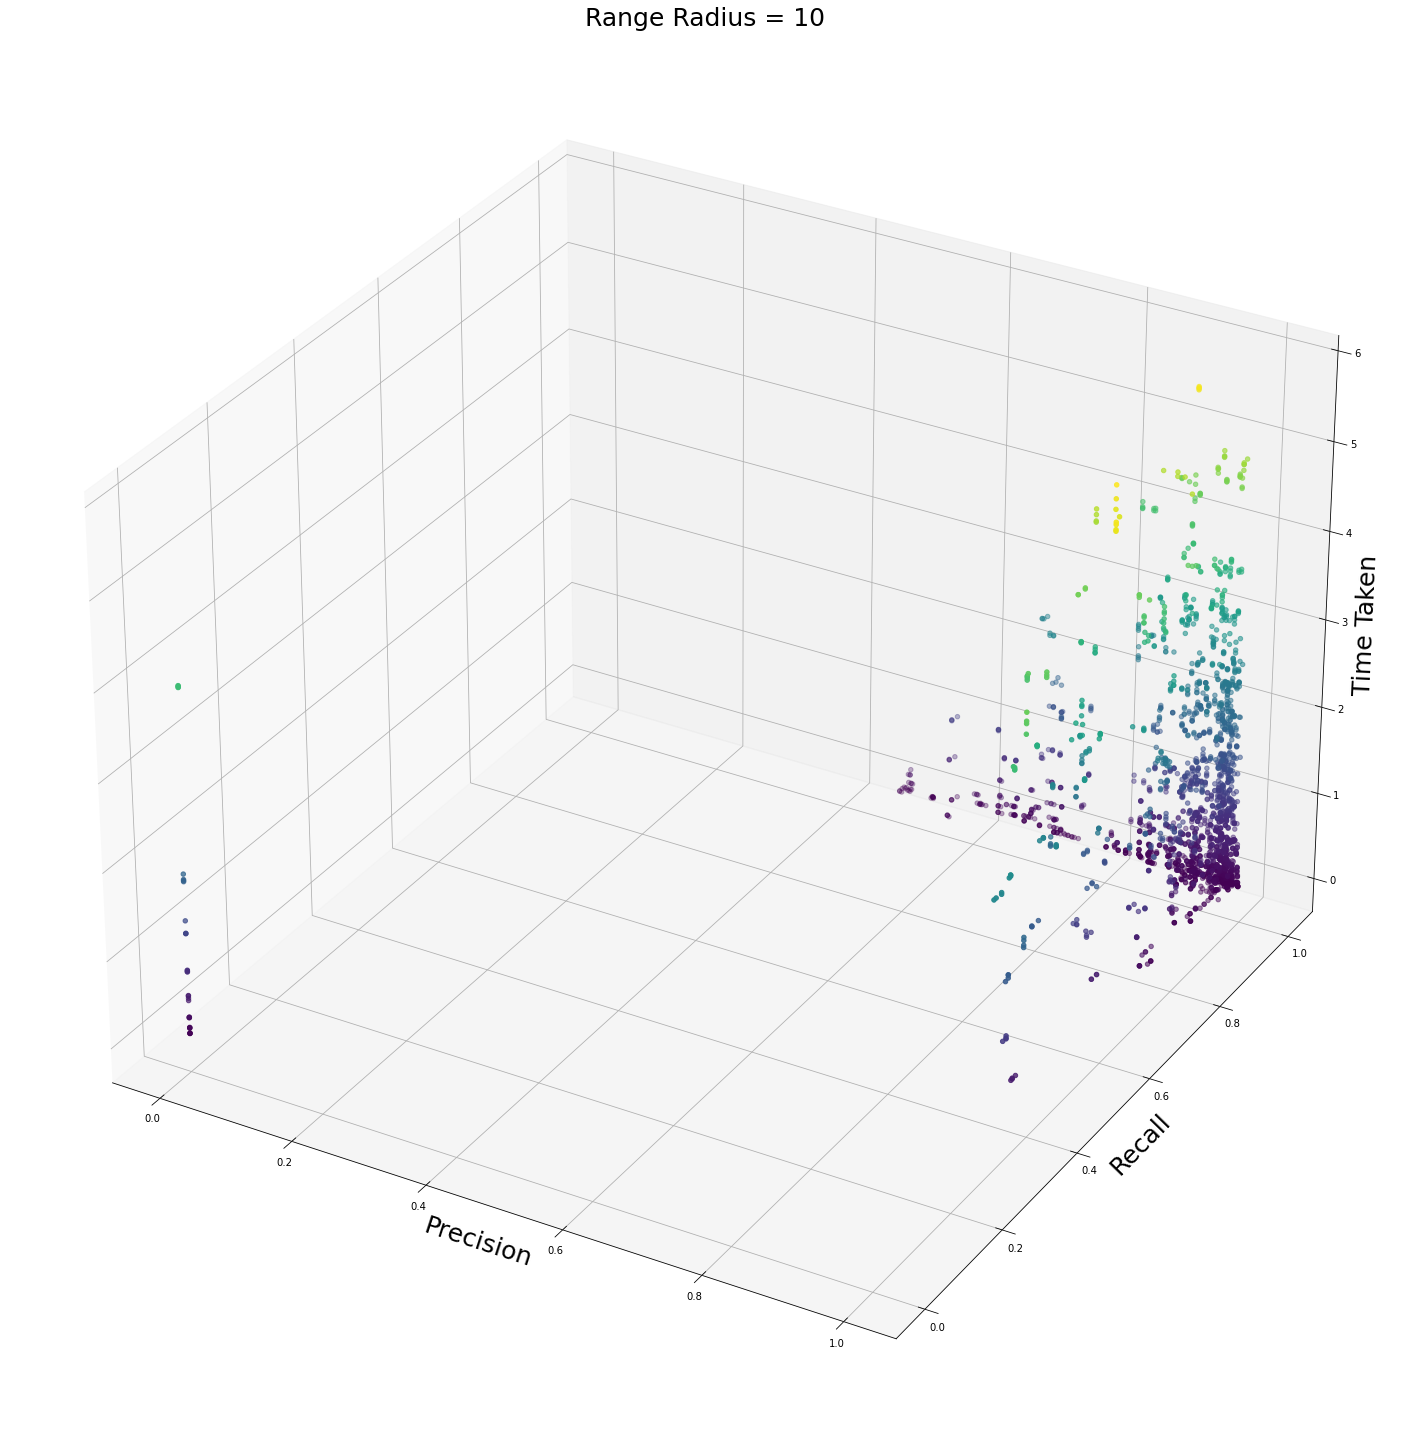

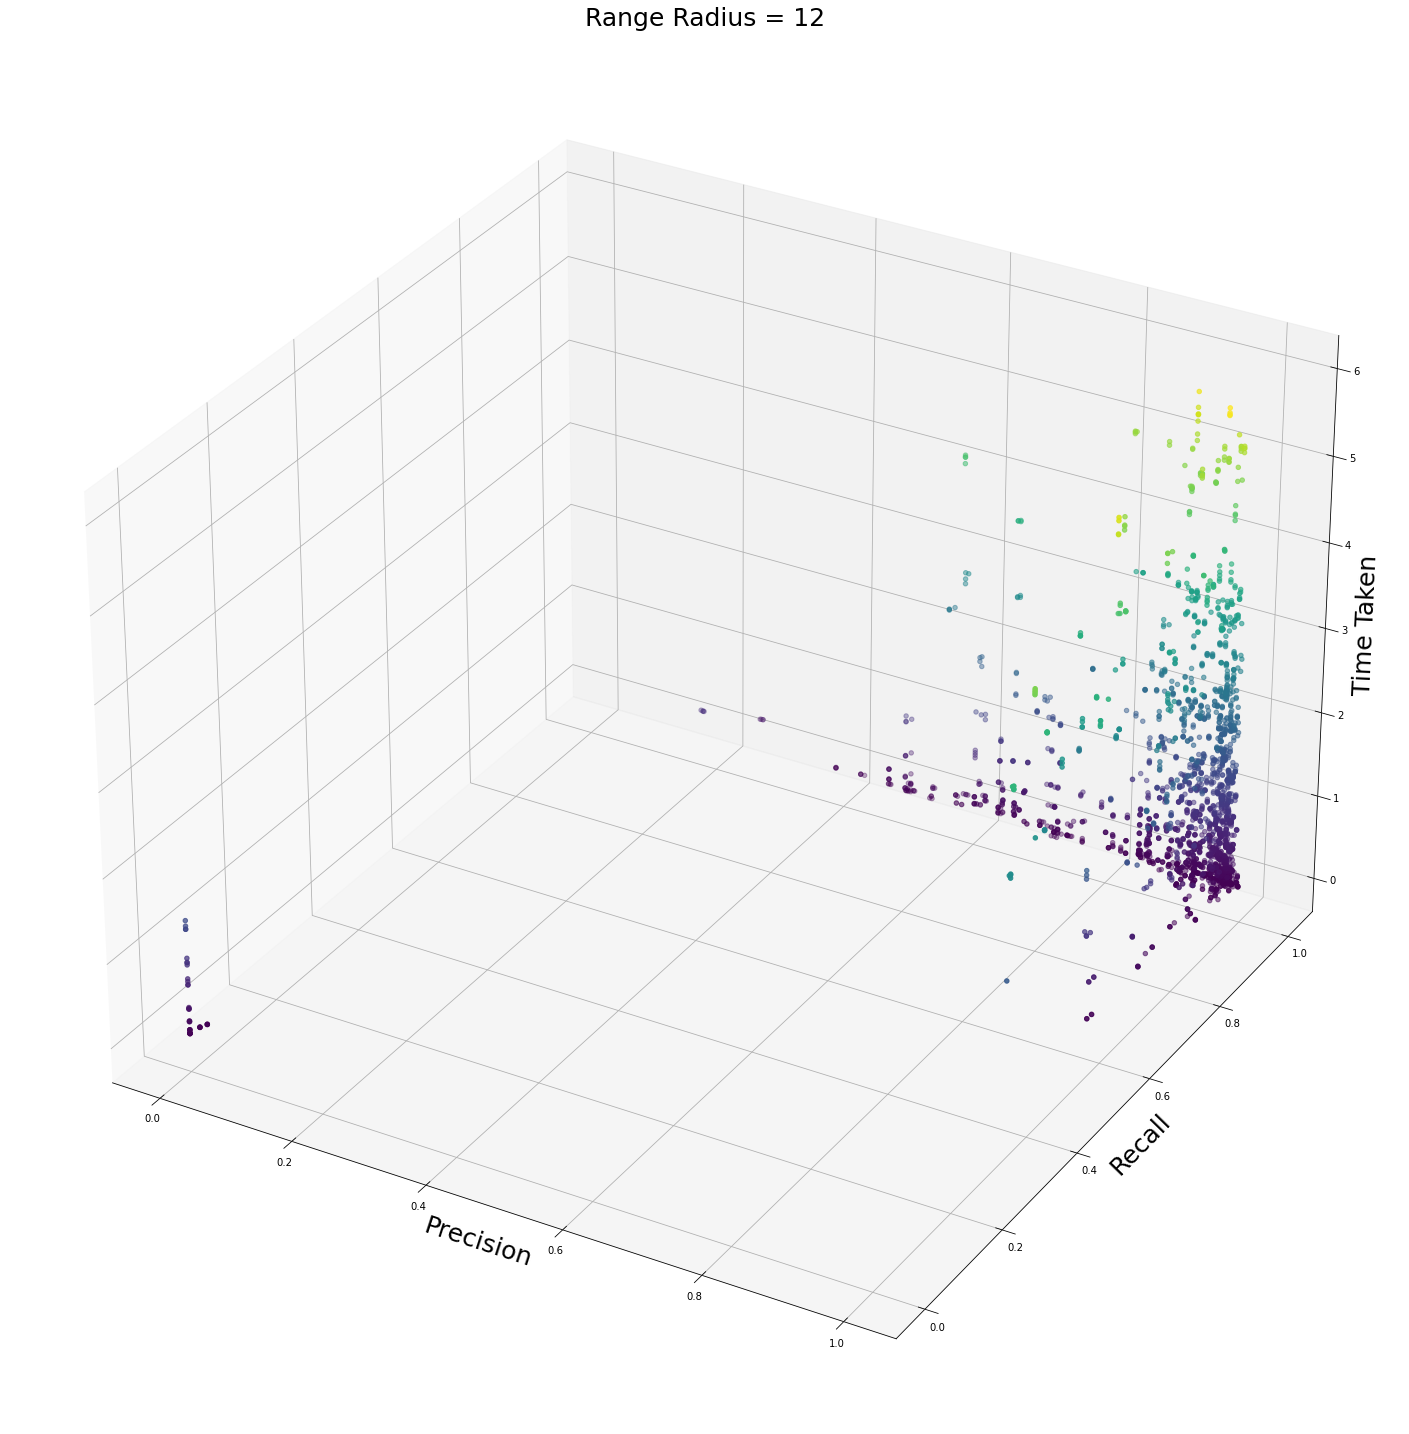

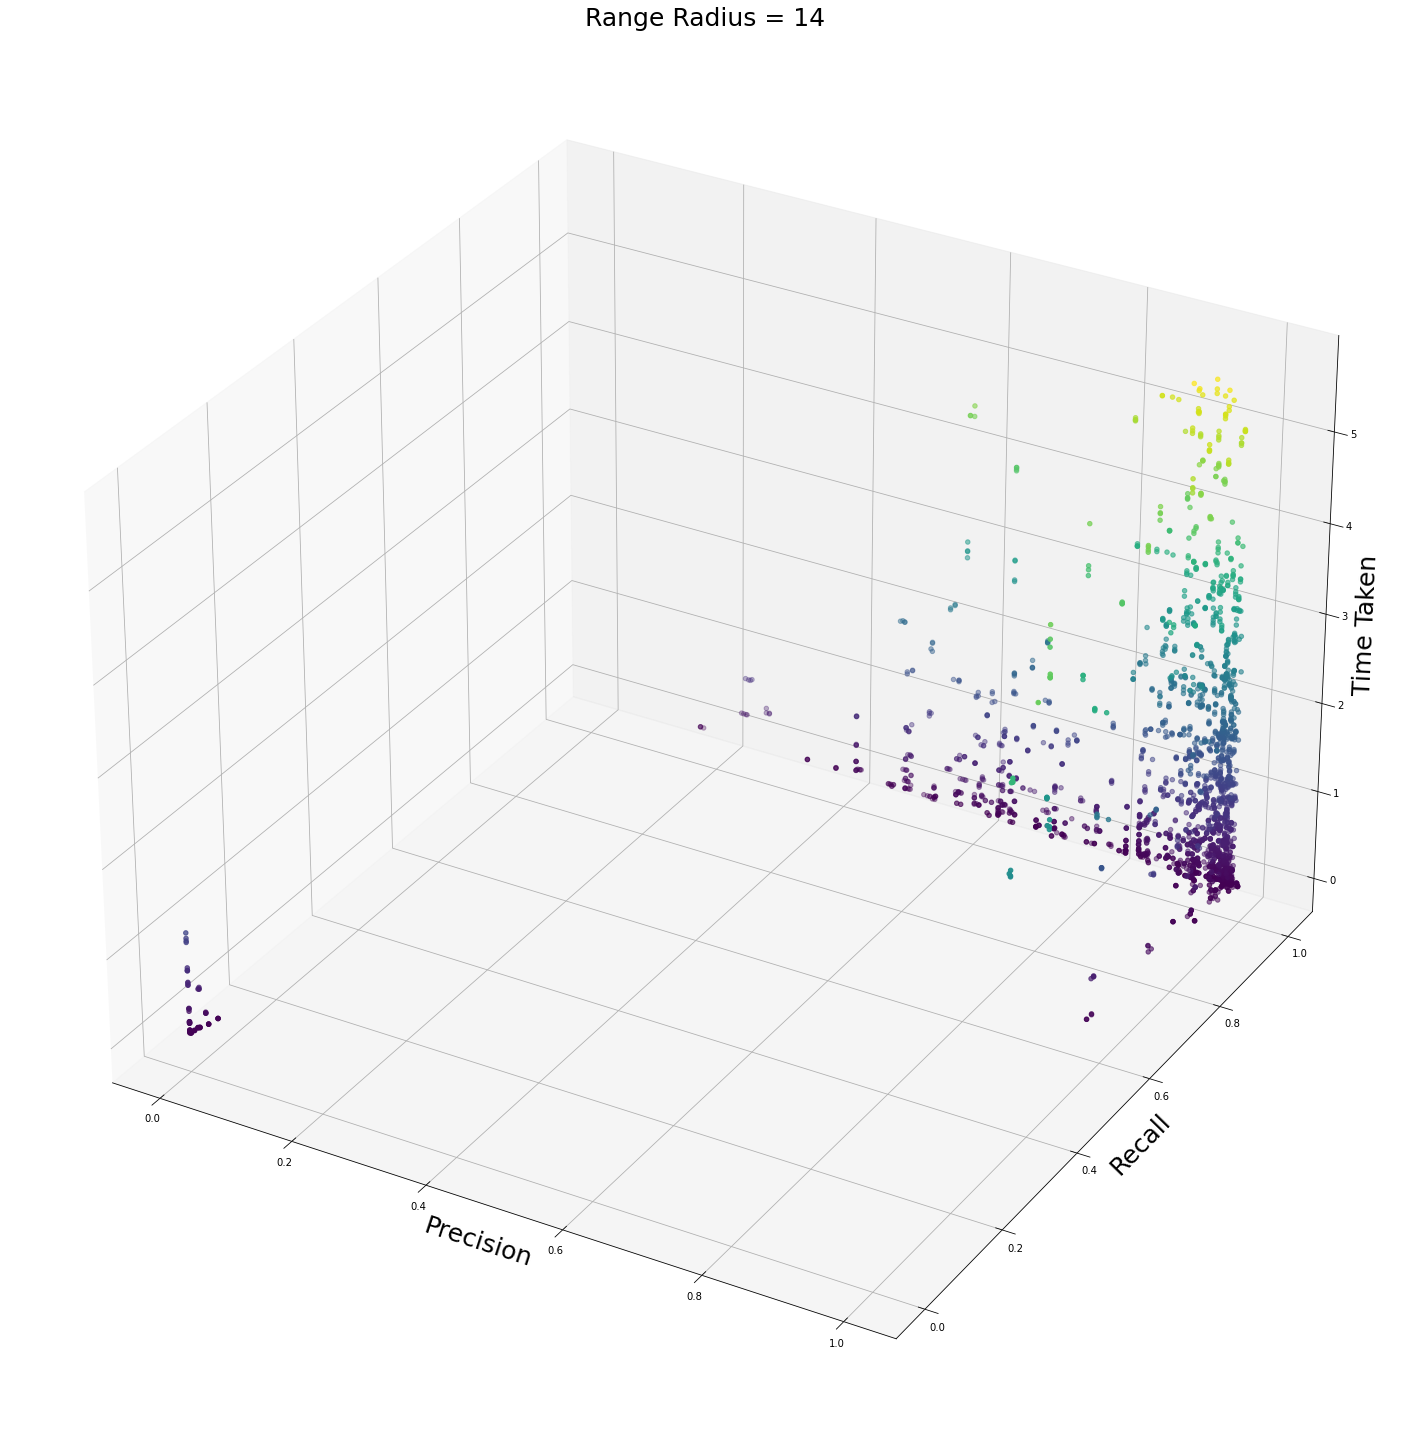

In [91]:
#make a 3d plot of the result for precision, recall and time taken for each range_radius
for i in rr_array:
    fig = plt.figure(figsize=(25, 30))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(results['precision'][results['range_radius'] == i], results['recall'][results['range_radius'] == i], results['time_taken'][results['range_radius'] == i], c=results['time_taken'][results['range_radius'] == i], cmap='viridis')
    ax.set_xlabel('Precision', fontsize=25)
    ax.set_ylabel('Recall', fontsize=25)
    ax.set_zlabel('Time Taken', fontsize=25)
    ax.set_title('Range Radius = ' + str(i), fontsize=25)
    plt.show()

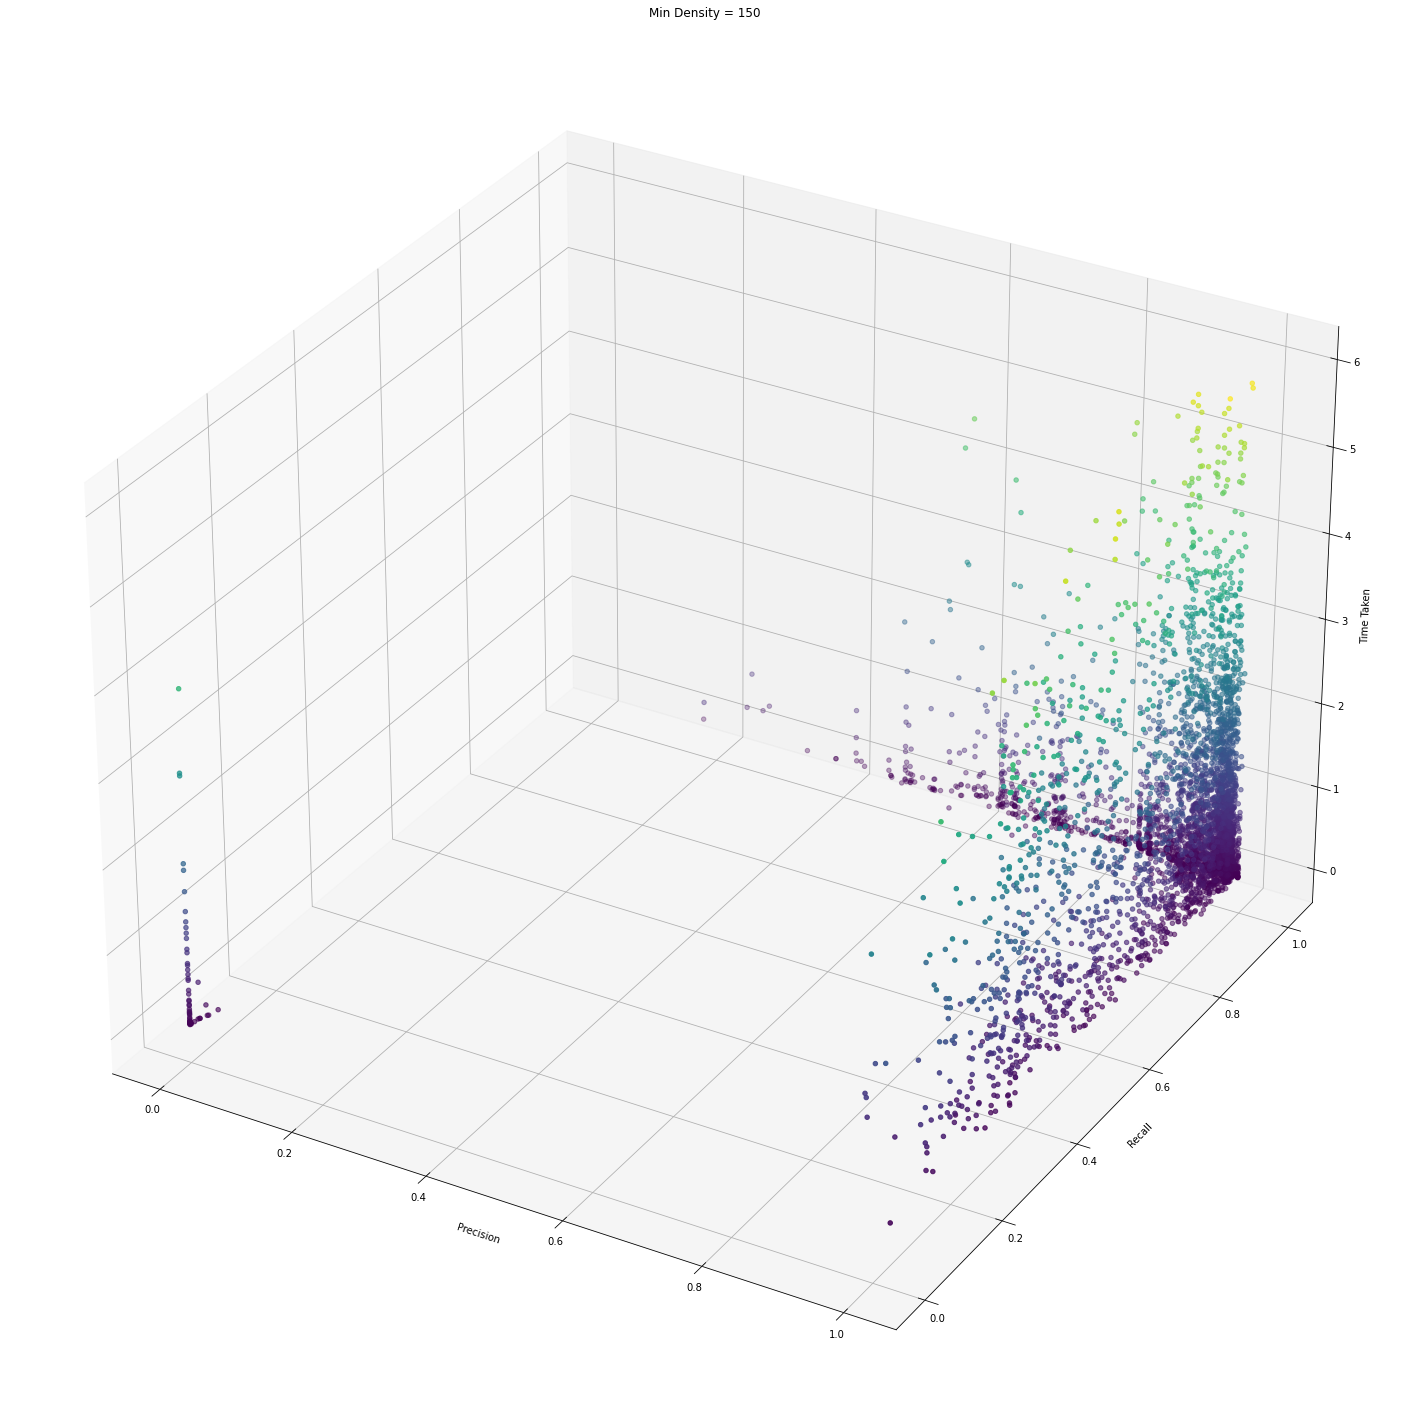

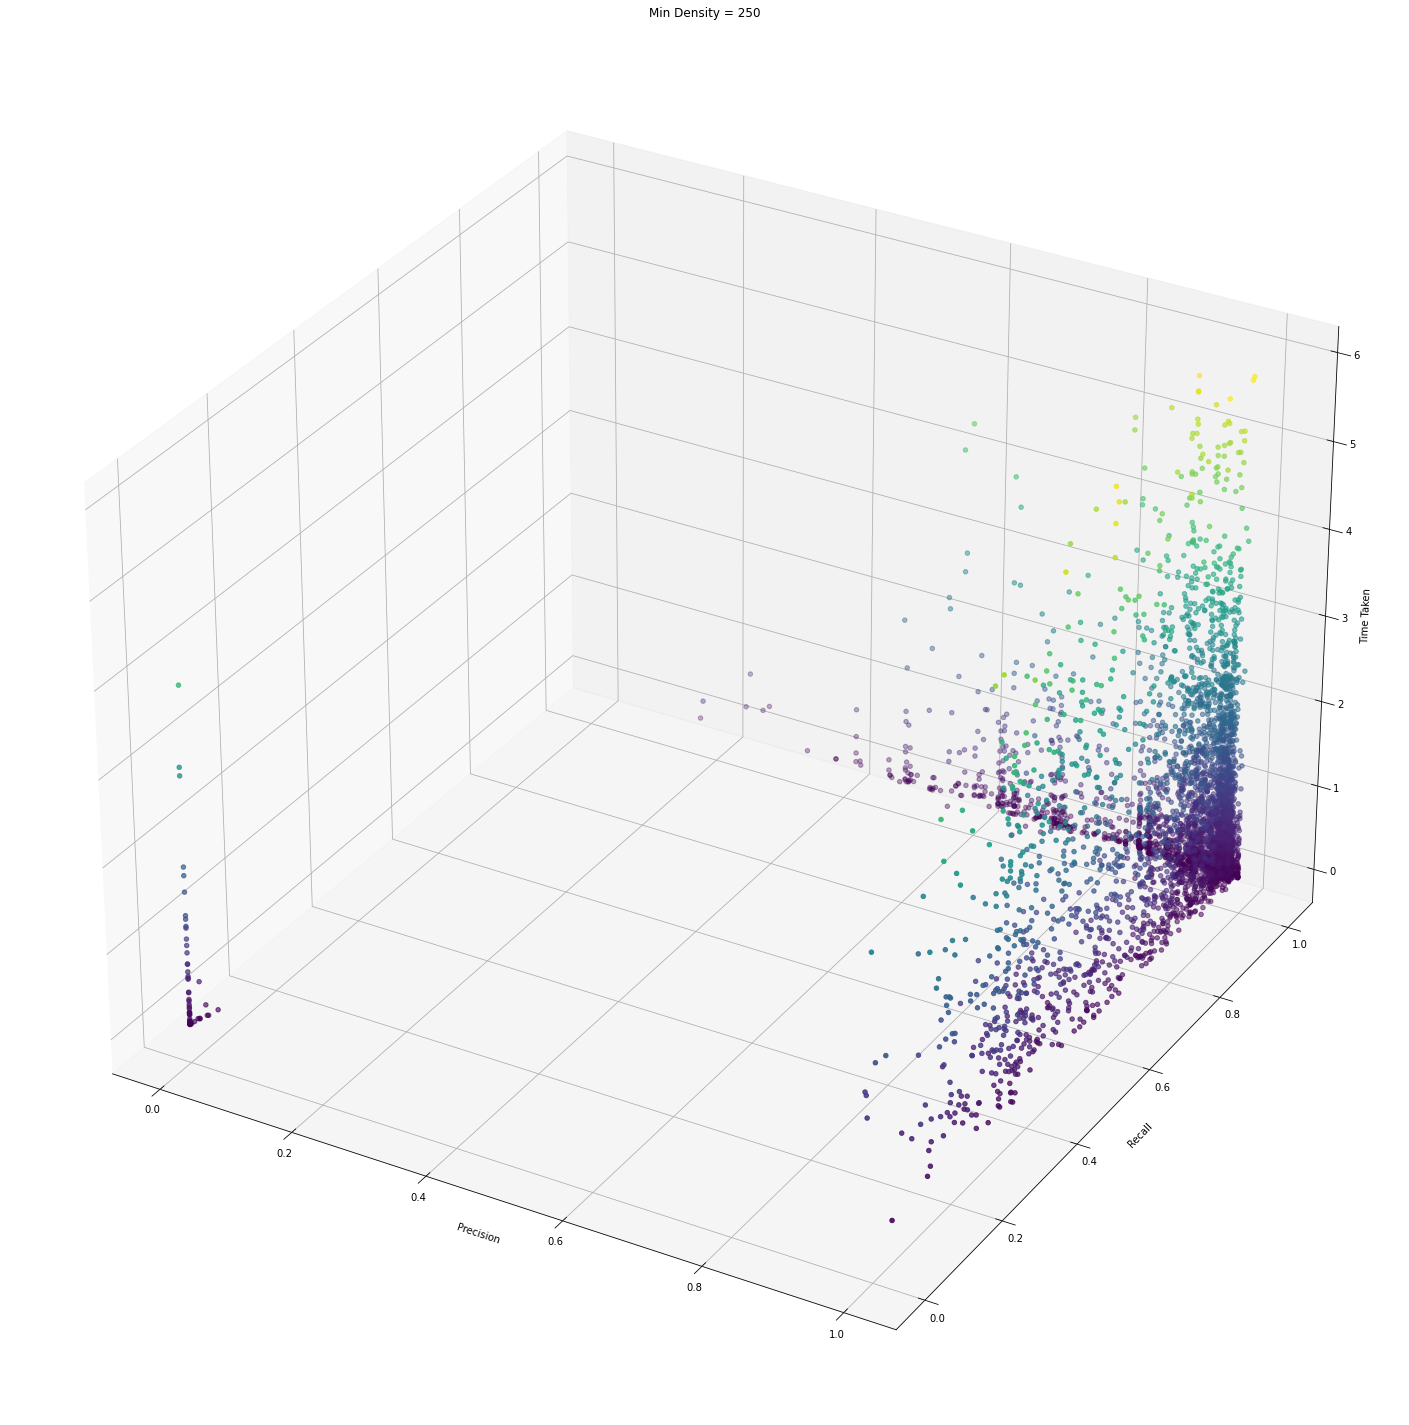

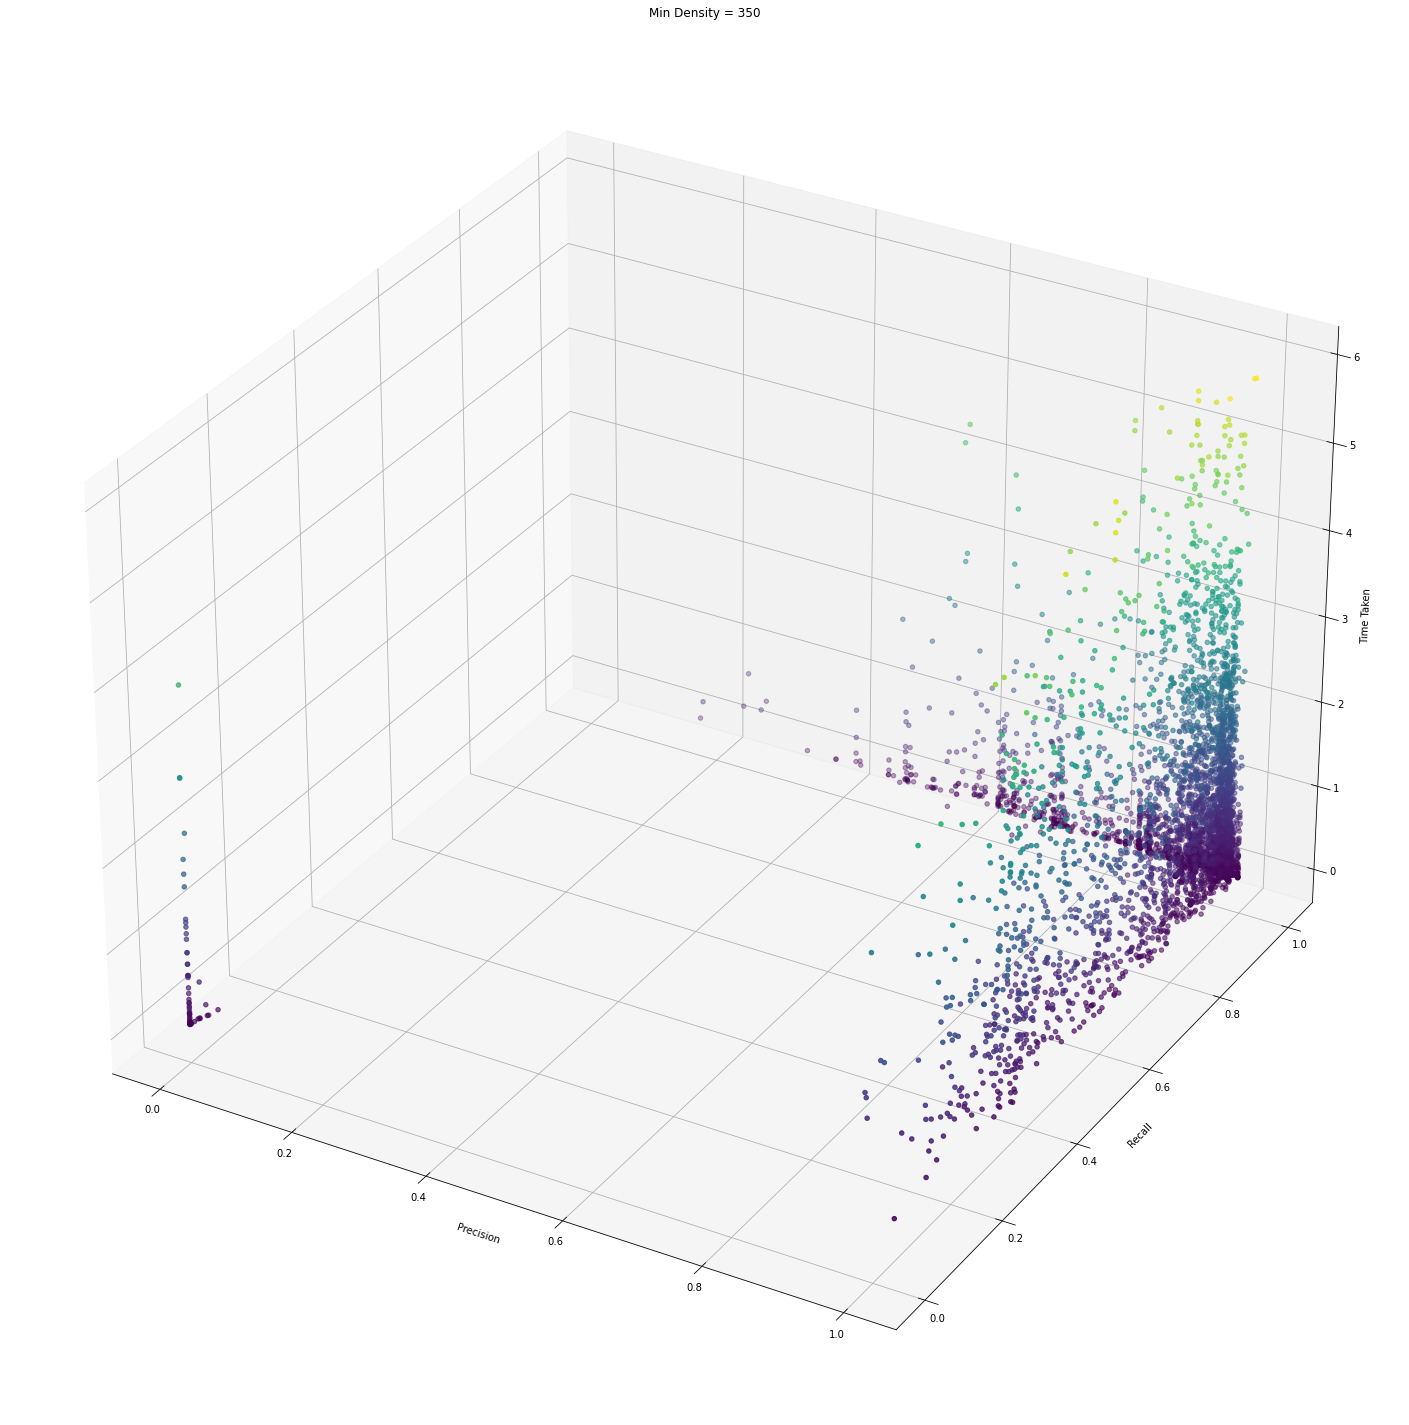

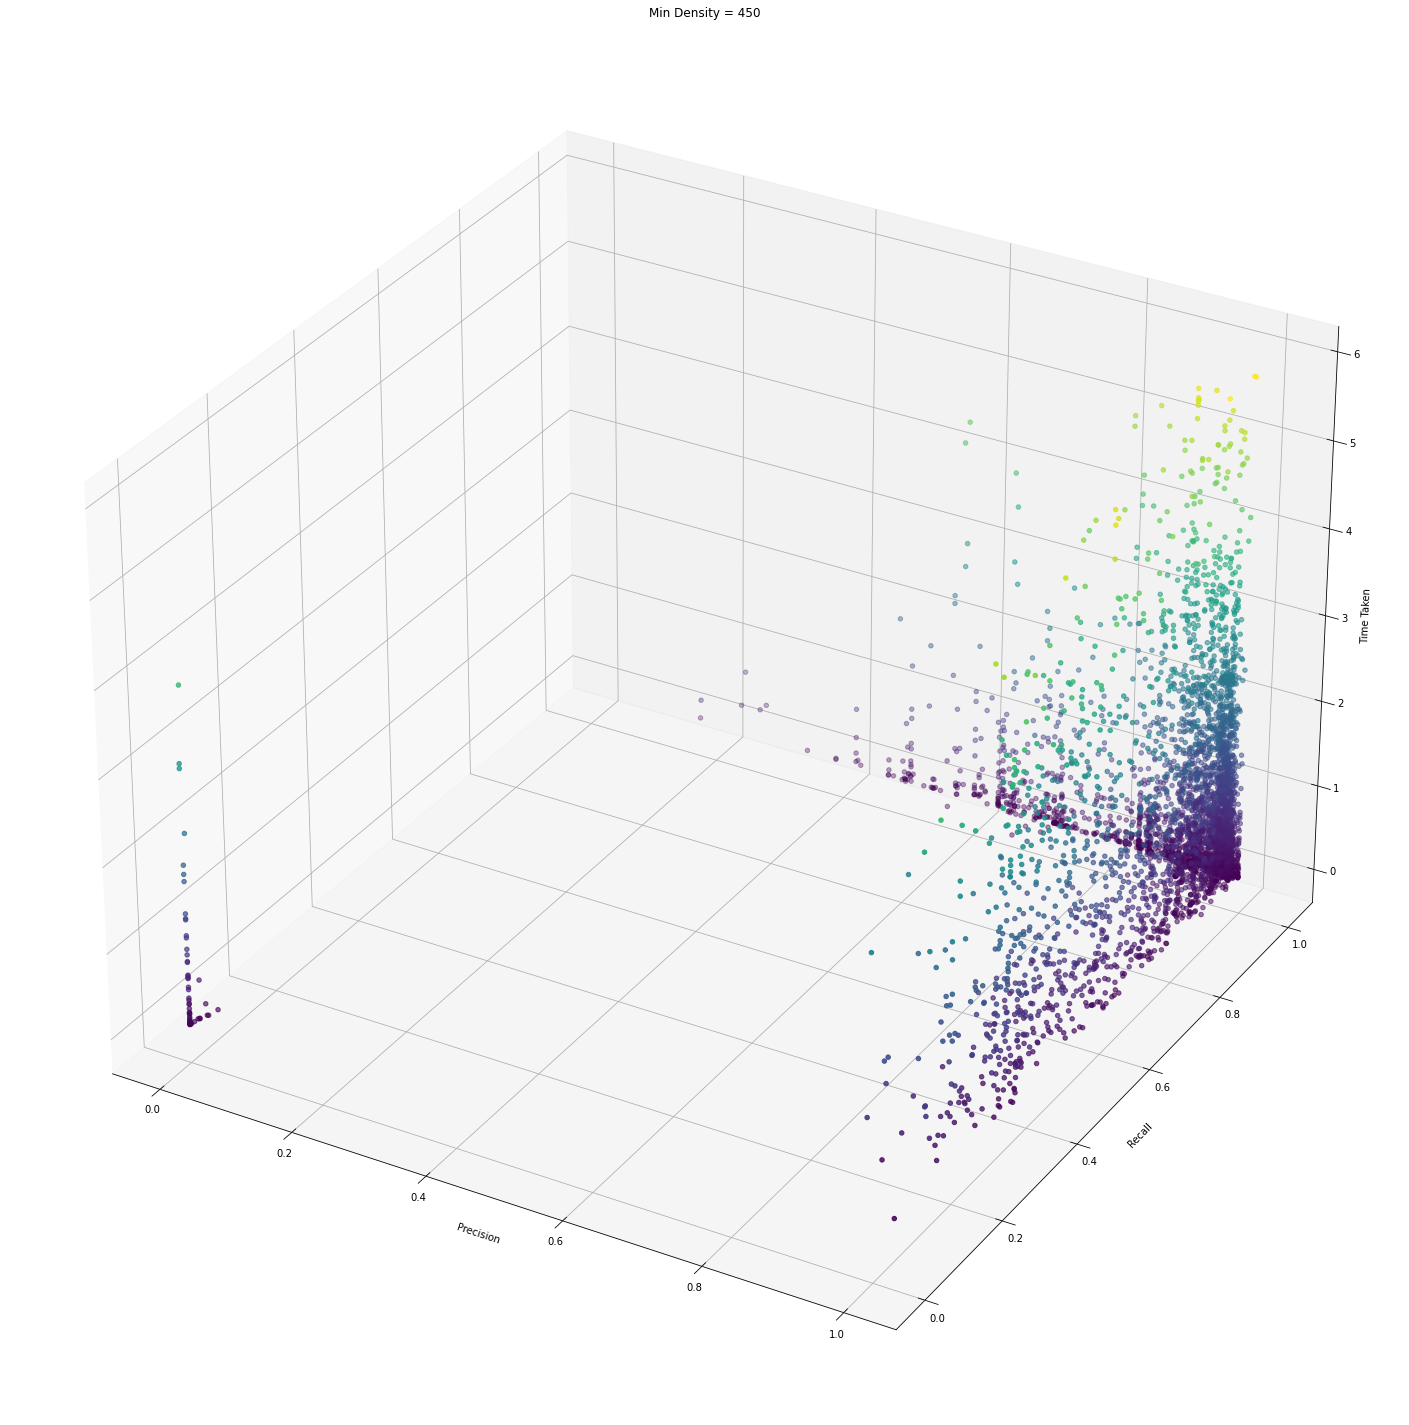

In [10]:
#make a 3d plot of the result for precision, recall and time taken for each min_density
for i in min_array:
    fig = plt.figure(figsize=(25, 30))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(results['precision'][results['min_density'] == i], results['recall'][results['min_density'] == i], results['time_taken'][results['min_density'] == i], c=results['time_taken'][results['min_density'] == i], cmap='viridis')
    ax.set_xlabel('Precision')
    ax.set_ylabel('Recall')
    ax.set_zlabel('Time Taken')
    ax.set_title('Min Density = ' + str(i))
    plt.show()

### Define Score Function

In [13]:
#define a function that takes precision, recall and time taken and return a non-linear combined weighted score
def score(precision, recall, time_taken):
    return (precision * recall) #/ (time_taken + 0.1)  #add something super small

#add a column to the results dataframe with the score
results['score'] = [score(precision, recall, time_taken) for precision, recall, time_taken in zip(results['precision'], results['recall'], results['time_taken'])]

#### Display Score Function graph

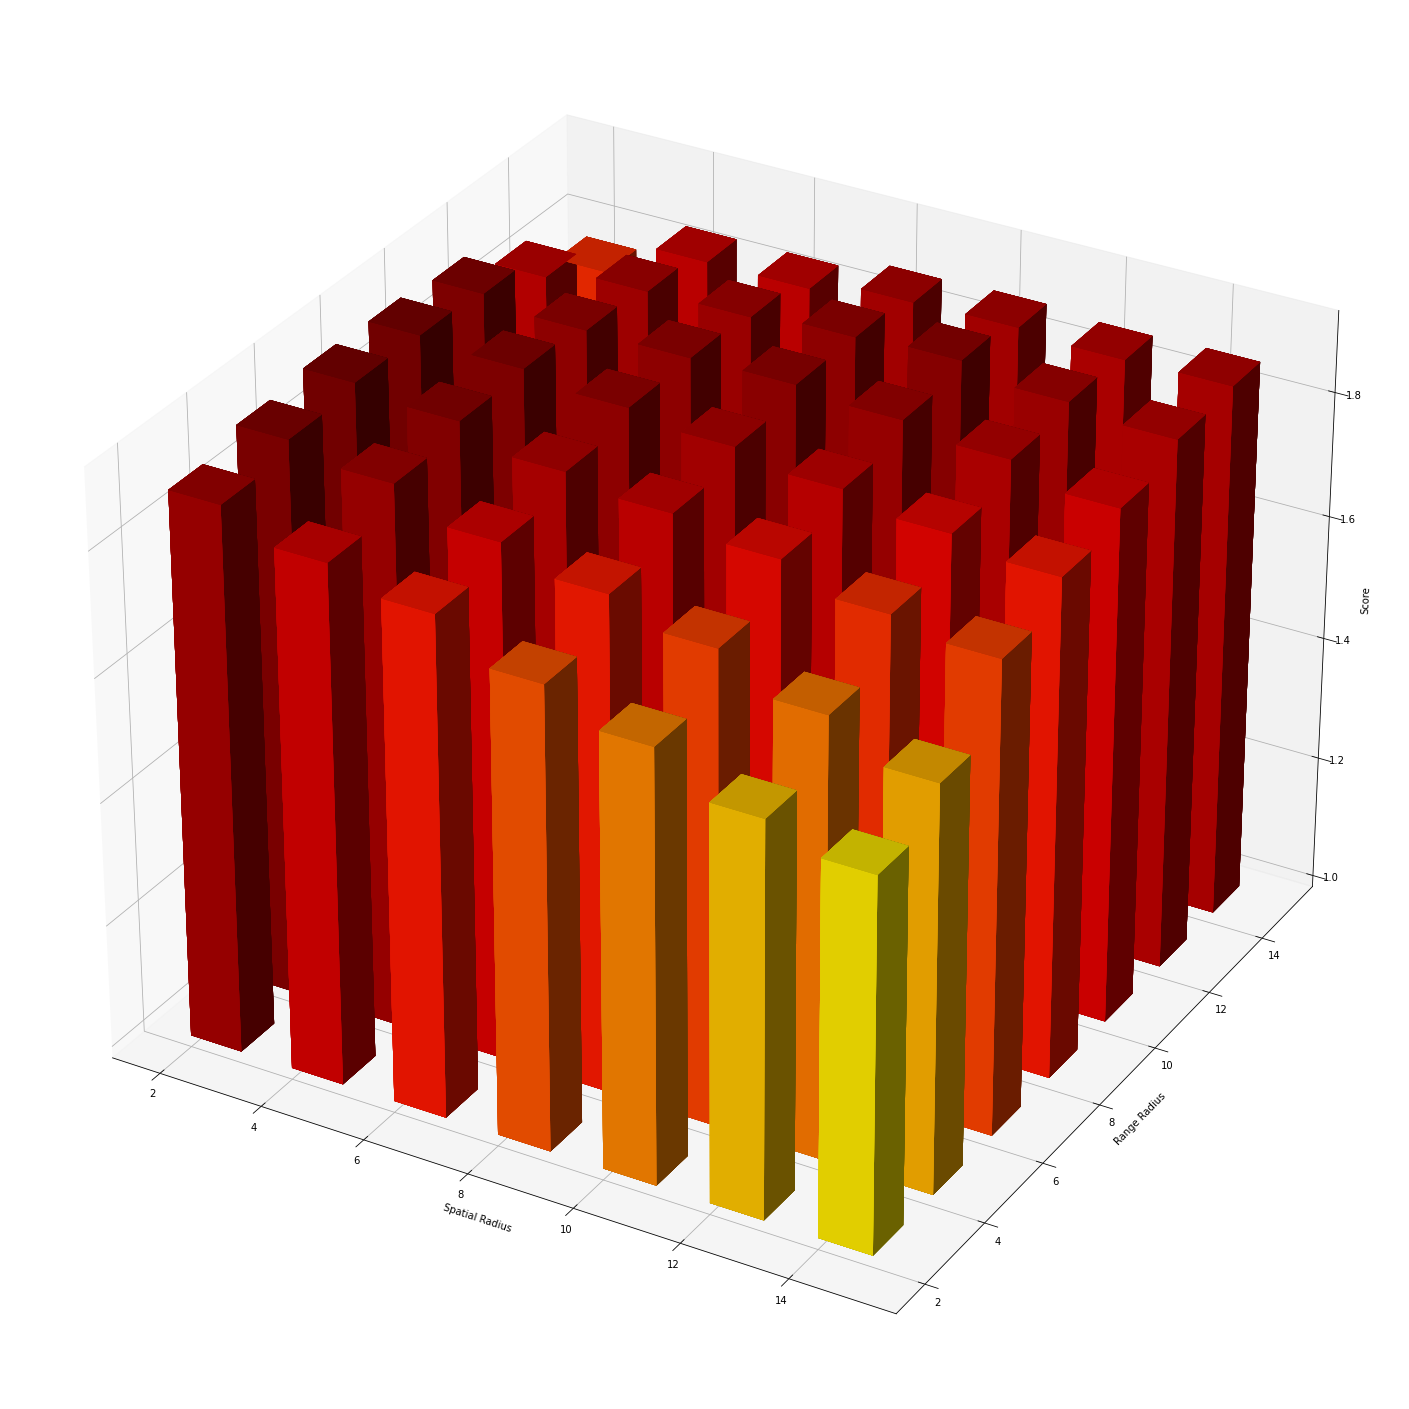

In [14]:
#get the average score for each spatial_radius, range_radius, and min_density and plot these values
score_array = []
for i in sr_array:
    for j in rr_array:
        for k in min_array:
            score_array.append([i, j, k, np.mean([l[8] for l in [m for m in [n for n in results.values if n[5] == i] if m[6] == j] if l[7] == k])])

#for each spatial_radius and range_radius, take the mean score value
score_array = [[i[0], i[1], np.mean([j[3] for j in [k for k in score_array if k[0] == i[0]] if j[1] == i[1]])] for i in score_array]

from matplotlib import cm

cmap = cm.get_cmap('jet')
#get the max and min score
max_score = max([k[2] for k in score_array])
min_score = min([k[2] for k in score_array])
rgba = [cmap((k[2])/max_score) for k in score_array] 

#plot a 3D bar plot of the score for each x axis as spatial_radius, y axis as range_radius, and z axis as score
fig = plt.figure(figsize=(25, 30))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d([i[0] for i in score_array], [i[1] for i in score_array], 1, 1, 1, [i[2] for i in score_array], color=rgba)
ax.set_xlabel('Spatial Radius')
ax.set_ylabel('Range Radius')
ax.set_zlabel('Score')
plt.show()

#### Worst Performing Case

------------------------------------------------------------------------------------------------------------------------
Processing: 7233, spatial_radius: 2, range_radius: 12, min_density: 350
Time taken:  0.05899977684020996


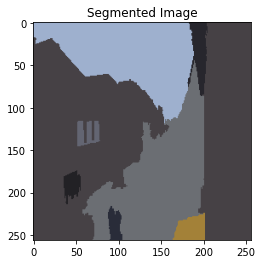

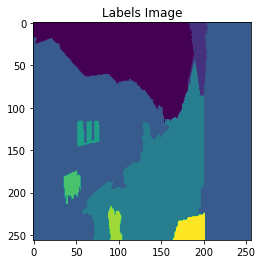

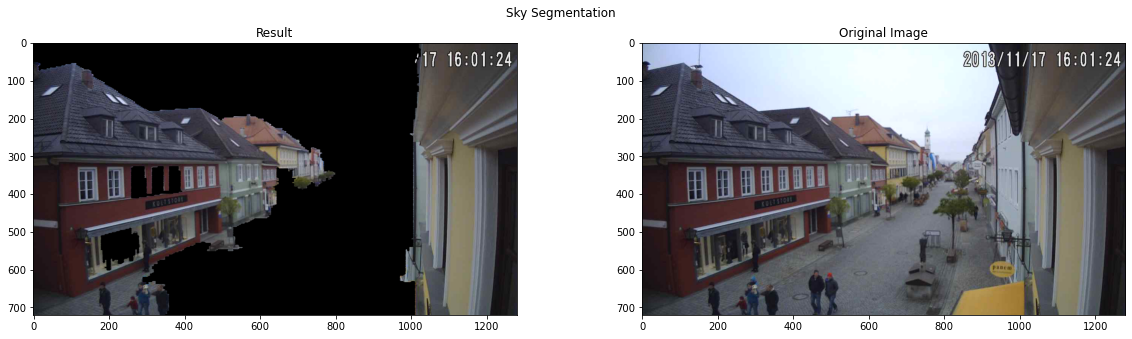

Precision: 5.966587112171838e-06
Recall: 1.9582373253089118e-05
F1: 9.146355406029583e-06
------------------------------------------------------------------------------------------------------------------------


In [32]:
#show the results for the lowest score values
for i in results.sort_values(by=['score'], ascending=True).head(1).values:
    display_results(i[3], display_mode = 'display' ,data_mode='validate', spatial_radius=i[5], range_radius=i[6], min_density=i[7])

#### Best Performing Case

------------------------------------------------------------------------------------------------------------------------
Processing: 75, spatial_radius: 2, range_radius: 14, min_density: 250
Time taken:  0.03799939155578613


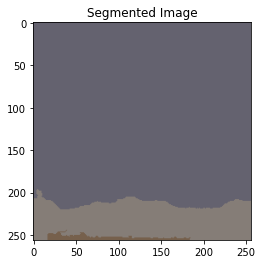

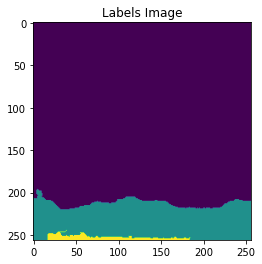

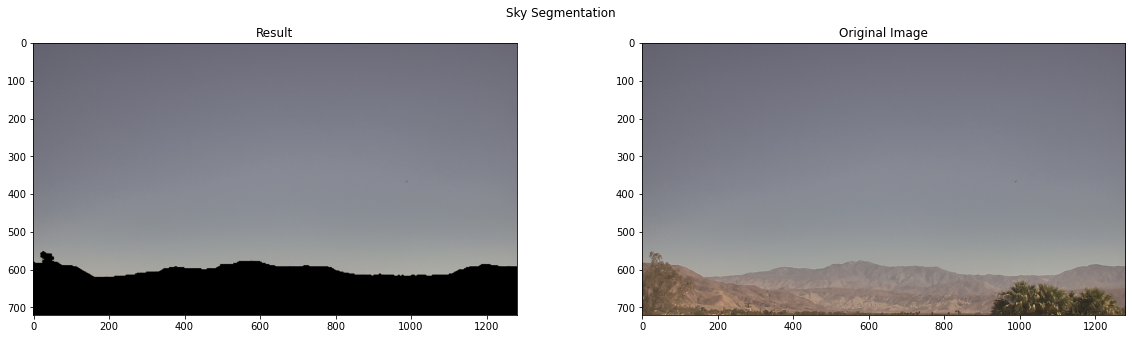

Precision: 0.997141468563993
Recall: 0.9981938764433621
F1: 0.9976673949657822
------------------------------------------------------------------------------------------------------------------------


In [33]:
#show the scores for the highest score values
for i in results.sort_values(by=['score'], ascending=False).head(1).values:
    display_results(i[3], display_mode = 'display' ,data_mode='validate', spatial_radius=i[5], range_radius=i[6], min_density=i[7])

### Mean Shift Segmentation for Video

In [38]:
cap = cv2.VideoCapture('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset\\video_4.mp4')
result = cv2.VideoWriter('saved_video_4.avi', cv2.VideoWriter_fourcc(*'MJPG'), 10, (int(cap.get(3)), int(cap.get(4))))

counter = 0

while cap.isOpened():
    ret, frame = cap.read()
    if ret == True:
        if counter % 2 == 0:
            start_time = time.time()
            frame = cv2.rotate(frame, cv2.ROTATE_180)
            mask, segmented_image, labels_image = mean_shift(frame, spatial_radius=7, range_radius=7, min_density=200)
            after_img = cv2.bitwise_and(frame, frame, mask=mask)
            segmented_image = cv2.resize(segmented_image, (int(cap.get(3)), int(cap.get(4))))
            result.write(after_img)
            print("Time taken: ", time.time() - start_time, "s")
        counter += 1
    else:
        break

Time taken:  0.6514055728912354 s
Time taken:  0.6562507152557373 s
Time taken:  0.6336736679077148 s
Time taken:  0.6221697330474854 s
Time taken:  0.6465859413146973 s
Time taken:  0.6549358367919922 s
Time taken:  0.6382110118865967 s
Time taken:  0.6216704845428467 s
Time taken:  0.6381237506866455 s
Time taken:  0.645172119140625 s
Time taken:  0.6450247764587402 s
Time taken:  0.6286699771881104 s
Time taken:  0.6331276893615723 s
Time taken:  0.6510655879974365 s
Time taken:  0.6513335704803467 s
Time taken:  0.6392295360565186 s
Time taken:  0.6330990791320801 s
Time taken:  0.6451401710510254 s
Time taken:  0.6240947246551514 s
Time taken:  0.6426117420196533 s
Time taken:  0.6170978546142578 s
Time taken:  0.6371481418609619 s
Time taken:  0.6230912208557129 s
Time taken:  0.6251082420349121 s
Time taken:  0.6321203708648682 s
Time taken:  0.6311004161834717 s
Time taken:  0.6286320686340332 s
Time taken:  0.6391017436981201 s
Time taken:  0.6341376304626465 s
Time taken:  0.

#### Metrics: Precision, Recall, F1-Score

In [8]:
def plot_all_varaitions(results, sort_by, sr, rr, min):
    #sort (0 = Precision, 1 = Recall, 2 = F1)
    results.sort(key=lambda x: x[sort_by])

    #display the subplots for all metrics in one plot
    fig, axs = plt.subplots(3, 1, figsize=(30, 10))
    axs[0].plot([i[0] for i in results], label="Precision")
    axs[0].set_title('Precision, Spatial Radius = ' + str(sr) + ', Range Radius = ' + str(rr) +', Min Density = ' + str(min))
    axs[1].plot([i[1] for i in results], label="Recall", color='orange')
    axs[1].set_title('Recall, Spatial Radius = ' + str(sr) + ', Range Radius = ' + str(rr) +', Min Density = ' + str(min))
    axs[2].plot([i[2] for i in results], label="F1", color='green')
    axs[2].set_title('F1, Spatial Radius = ' + str(sr) + ', Range Radius = ' + str(rr) +', Min Density = ' + str(min))
    plt.show()

## Neural Network + Mean Shift Approach

#### Imports

In [46]:
import cv2
import pandas as pd
import pymeanshift as pms
import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import IntProgress
from IPython.display import display
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

INPUT_CSV_FILE = "C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\image_segmented.csv"
OUTPUT_CSV_FILE = "label_separated.csv"
SAVE_EVERY_N_IMAGES = 10

#### Prepare new dataset

In [102]:
#Read the CSV file into a pandas DataFrame
df = pd.read_csv(INPUT_CSV_FILE)

#Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['image_path', 'label', 'num_pixels', 'cX', 'cY', 'ground_truth'])

#Initiate a progress bar
progress = IntProgress(min=0, max=len(df))
display(progress)

# Loop through each row in the DataFrame
for index, row in df.iterrows():
    print("Now processing image", index, "of", len(df), "...", end="\r")
    # Load the image and label
    image = plt.imread(row['image_path'])
    label = plt.imread(row['label'], 0)  # Load as grayscale

    #resize the images to 256x256
    image = cv2.resize(image, (256, 256))
    label = cv2.resize(label, (256, 256))
    
    # Perform mean shift segmentation
    (segmented_image, labels_image, number_regions) = pms.segment(image, spatial_radius=2, range_radius=8, min_density=250)
    
    # Loop through each label in the labels image
    for i in range(0, number_regions):
        # Create a mask for the current label
        mask = (labels_image == i).astype('uint8')
        
        # Apply the mask to the original image and the label
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        masked_label = cv2.bitwise_and(label, label, mask=mask)
        
        # Compute the average color and number of pixels in the masked image
        average_color = cv2.mean(masked_image, mask=mask)[:3]
        num_pixels = mask.sum()

        #find the center of the mask
        M = cv2.moments(mask)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        
        # Check if all pixels in the masked label are 1
        ground_truth = float((masked_label == 1).sum()/num_pixels)
        
        # Add the results to the results DataFrame
        results_df = results_df.append({
            'image_path': row['image_path'],
            'label': i,
            'R' : average_color[0],
            'G' : average_color[1],
            'B' : average_color[2],
            'num_pixels': num_pixels,
            'ground_truth': ground_truth,
            'cX': cX,
            'cY': cY
        }, ignore_index=True)  #type:ignore

    progress.value += 1
    
    # Save the results to a CSV file every SAVE_EVERY_N_IMAGES images
    if index > 0 and index % SAVE_EVERY_N_IMAGES == 0:
        results_df.to_csv(OUTPUT_CSV_FILE, mode='a', index=False, header=False)
        results_df = pd.DataFrame(columns=['image_path', 'label', 'average_color', 'num_pixels', 'ground_truth'])

IntProgress(value=0, max=38082)

                                           image_path label num_pixels   cX  \
0   C:\Users\cjbla\OneDrive\Desktop\Code\data\segm...     0      43082  119   
1   C:\Users\cjbla\OneDrive\Desktop\Code\data\segm...     1      11998  159   
2   C:\Users\cjbla\OneDrive\Desktop\Code\data\segm...     2       3055  128   
3   C:\Users\cjbla\OneDrive\Desktop\Code\data\segm...     3        257  120   
4   C:\Users\cjbla\OneDrive\Desktop\Code\data\segm...     4       1377  154   
5   C:\Users\cjbla\OneDrive\Desktop\Code\data\segm...     5        306  222   
6   C:\Users\cjbla\OneDrive\Desktop\Code\data\segm...     6        806   33   
7   C:\Users\cjbla\OneDrive\Desktop\Code\data\segm...     7        426  126   
8   C:\Users\cjbla\OneDrive\Desktop\Code\data\segm...     8        741   18   
9   C:\Users\cjbla\OneDrive\Desktop\Code\data\segm...     9        760  176   
10  C:\Users\cjbla\OneDrive\Desktop\Code\data\segm...    10       1001  157   
11  C:\Users\cjbla\OneDrive\Desktop\Code\data\segm..

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ground_truth'>

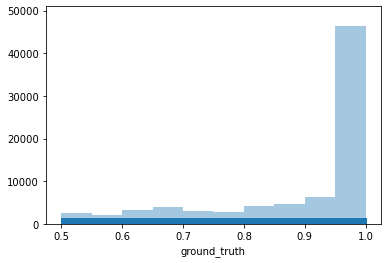

In [76]:
#import the data
df = pd.read_csv(OUTPUT_CSV_FILE)

#make a distriubtion plot of the ground truth values between 0 and 1
df_temp = df[df['ground_truth'] > 0.5]
sns.distplot(df_temp['ground_truth'], bins=10, kde=False, rug=True)

### Undersampling the 0 class

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ground_truth'>

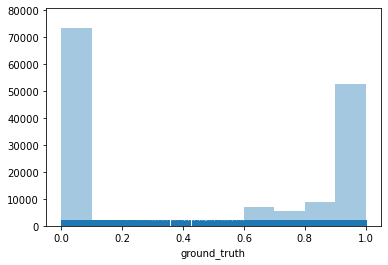

In [77]:
# Separate the rows with ground_truth below 0.8
df_below_08 = df[df['ground_truth'] < 0.6]

# Separate the rows with ground_truth above or equal to 0.8
df_above_08 = df[df['ground_truth'] >= 0.6]

# Undersample the rows with ground_truth below 0.8 to match the number of rows with ground_truth above or equal to 0.8
df_below_08_resampled = resample(df_below_08, replace=False, n_samples=len(df_above_08))

# Combine the undersampled and original rows back into a single DataFrame
df_resampled = pd.concat([df_below_08_resampled, df_above_08])

sns.distplot(df_resampled['ground_truth'], bins=10, kde=False, rug=True)

In [78]:
# Split the data into training and testing sets
df_resampled_dropped = df_resampled.drop('image_path', axis=1)

# Split the 'average_color' column into separate R, G, and B columns
df_resampled_dropped[['R', 'G', 'B']] = df_resampled_dropped['average_color'].str.strip('()').str.split(',', expand=True).astype(float)

#normalize the data using scikit-learn's MinMaxScaler
scaler = MinMaxScaler()
df_resampled_dropped[['num_pixels', 'R', 'G', 'B', 'label']] = scaler.fit_transform(df_resampled_dropped[['num_pixels', 'R', 'G', 'B', 'label']])

df_resampled_dropped = df_resampled_dropped.drop('average_color', axis=1)

# Split the data into training and testing sets
train_data = df_resampled_dropped.sample(frac=0.8, random_state=1)
test_data = df_resampled_dropped.drop(train_data.index)

# Convert the data into numpy arrays
train_labels = train_data.pop('ground_truth').values
train_features = train_data.values

test_labels = test_data.pop('ground_truth').values
test_features = test_data.values

### Model

In [79]:
def create_model(input_shape):
    # Define the input layer
    inputs = keras.Input(shape=input_shape)

    # Define the hidden layers
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)

    # Define the output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    return model

In [88]:
#Create the model
model = create_model(input_shape=(train_features.shape[1],))

# Train the model
model.fit(train_features, train_labels, epochs=50)

# Evaluate the model on the test set
test_loss = model.evaluate(test_features, test_labels)
print(f'Test loss: {test_loss:.2f}')

Epoch 1/50
3720/3720 [==============================] - 9s 2ms/step - loss: 0.0713
Epoch 2/50
3720/3720 [==============================] - 9s 2ms/step - loss: 0.0626
Epoch 3/50
3720/3720 [==============================] - 9s 2ms/step - loss: 0.0612
Epoch 4/50
3720/3720 [==============================] - 9s 2ms/step - loss: 0.0601
Epoch 5/50
3720/3720 [==============================] - 9s 2ms/step - loss: 0.0592
Epoch 6/50
3720/3720 [==============================] - 9s 2ms/step - loss: 0.0586
Epoch 7/50
3720/3720 [==============================] - 9s 2ms/step - loss: 0.0582
Epoch 8/50
3720/3720 [==============================] - 9s 2ms/step - loss: 0.0578
Epoch 9/50
3720/3720 [==============================] - 9s 2ms/step - loss: 0.0573
Epoch 10/50
3720/3720 [==============================] - 9s 2ms/step - loss: 0.0570
Epoch 11/50
3720/3720 [==============================] - 9s 2ms/step - loss: 0.0568
Epoch 12/50
3720/3720 [==============================] - 9s 2ms/step - loss: 0.0564
E

### Testing with real world data

In [59]:
# Create and display a FileChooser widget
fc = FileChooser('C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\dataset')
display(fc)

FileChooser(path='C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset', filename='', title='', show_hidden=False…

In [93]:
image = plt.imread(fc.selected)

#resize the image to 256x256
image = cv2.resize(image, (256, 256))
test_df = pd.DataFrame(columns=['label', 'num_pixels', 'R', 'G', 'B'])

(segmented_image, labels_image, number_regions) = pms.segment(image, spatial_radius=2, range_radius=8, min_density=250)
for i in range(0, number_regions):
        # Create a mask for the current label
        mask = (labels_image == i).astype('uint8')
        
        # Apply the mask to the original image and the label
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        
        # Compute the average color and number of pixels in the masked image
        average_color = cv2.mean(masked_image, mask=mask)[:3]
        num_pixels = mask.sum()

        #add the results to the test_df dataframe
        test_df = test_df.append({
            'label': i,
            'num_pixels': num_pixels,
            'R': average_color[0],
            'G': average_color[1],
            'B': average_color[2]
        }, ignore_index=True)  #type:ignore

        #scale using scaler
        test_df[['num_pixels', 'R', 'G', 'B', 'label']] = scaler.transform(test_df[['num_pixels', 'R', 'G', 'B', 'label']])

        #predict the ground truth value
        prediction = model.predict(test_df.values)
        print(prediction)
        

1/1 [==============================] - 0s 20ms/step
[[0.9161908]]
1/1 [==============================] - 0s 18ms/step
[[0.2806424]
 [0.000302 ]]
1/1 [==============================] - 0s 16ms/step
[[0.2680226 ]
 [0.2680227 ]
 [0.23998955]]
1/1 [==============================] - 0s 17ms/step
[[0.26799974]
 [0.26799974]
 [0.27776483]
 [0.10890946]]
1/1 [==============================] - 0s 17ms/step
[[0.26799974]
 [0.26799974]
 [0.26819277]
 [0.27307302]
 [0.30531076]]
1/1 [==============================] - 0s 18ms/step
[[0.26799974]
 [0.26799974]
 [0.26799974]
 [0.26803598]
 [0.26916856]
 [0.52809143]]
1/1 [==============================] - 0s 16ms/step
[[0.26799974]
 [0.26799974]
 [0.26799974]
 [0.26799974]
 [0.2680004 ]
 [0.27887183]
 [0.07431599]]
1/1 [==============================] - 0s 16ms/step
[[0.26799974]
 [0.26799974]
 [0.26799974]
 [0.26799974]
 [0.26799974]
 [0.26813558]
 [0.26830724]
 [0.02686526]]
1/1 [==============================] - 0s 16ms/step
[[0.26799974]
 [0.26799

Prediction: [0.26799974]
Index: 0
Label: 0.0
Number of pixels: -0.0001922704214260005
Average color: (3.741409081696957e-80, 3.707440488456278e-80, 3.56753658854857e-80)
Image: C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset\OriginalImages\11331\20140320_181122.jpg


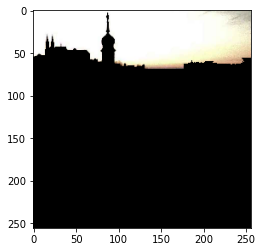

In [94]:
#print prediction and index where the value is greater than 0.8
for i in range(0, len(prediction)):
    if prediction[i] > 0.1:
        print(f"Prediction: {prediction[i]}")
        print(f"Index: {i}")
        print(f"Label: {test_df['label'][i]}")
        print(f"Number of pixels: {test_df['num_pixels'][i]}")
        print(f"Average color: {test_df['R'][i], test_df['G'][i], test_df['B'][i]}")
        print(f"Image: {fc.selected}")

        mask = (labels_image == i).astype('uint8')
        
        # Apply the mask to the original image and the label
        masked_image = cv2.bitwise_and(image, image, mask=mask)

        plt.imshow(masked_image)
        plt.show()
        break